<a href="https://colab.research.google.com/github/Yangl1492/Fraud-Detection/blob/main/Yang_Final_Project_1.0_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import os
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
!pip install category_encoders
from category_encoders.cat_boost import CatBoostEncoder
from sklearn import svm
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
!pip install catboost
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve,specificity_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
import torch
import random
import joblib
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report
import torch.nn as nn
import logging
import itertools
import torch.optim as optim
from sklearn.metrics import roc_curve
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping


import warnings
warnings.filterwarnings('ignore')

In [5]:
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/MyDrive/Colab Notebooks")
import altair as alt
from IPython.display import display

Mounted at /content/gdrive


# Data Load and preprocessing

In [6]:
df = pd.read_csv('train_all_inner.csv', index_col = 0)
print(df.shape)
df.head()

(144233, 434)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,0,86549,75.887,C,16496,352.0,117.0,mastercard,134.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,0,86555,16.495,C,4461,375.0,185.0,mastercard,224.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0,86620,30.000,H,1790,555.0,150.0,visa,226.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [7]:
# NULL Value Table
def create_summary_table(df):
  summary = pd.DataFrame(index = df.columns)
  summary['Data Type'] = df.dtypes.values
  summary['# Nonnull records'] = df.count().values
  summary['# Non-zero records'] = df.astype(bool).sum(axis=0)
  summary['% null records'] = round(df.isna().sum()/df.shape[0]*100,2)
  summary['% non-zero records'] = round(df.astype(bool).sum(axis=0) / df.shape[0]*100,2)
  summary['Unique values'] = df.nunique().values
  summary.to_csv('summary_table.csv')
  return summary

In [8]:
summary = create_summary_table(df)
summary

,Data Type,# Nonnull records,# Non-zero records,% null records,% non-zero records,Unique values
TransactionID,int64,144233,144233,0.00,100.00,144233
isFraud,int64,144233,11318,0.00,7.85,2
TransactionDT,int64,144233,144233,0.00,100.00,142734
TransactionAmt,float64,144233,144233,0.00,100.00,7830
ProductCD,object,144233,144233,0.00,100.00,4
...,...,...,...,...,...,...
id_36,object,140985,144233,2.25,100.00,2
id_37,object,140985,144233,2.25,100.00,2
id_38,object,140985,144233,2.25,100.00,2
DeviceType,object,140810,144233,2.37,100.00,2


In [9]:
summary.to_csv('summary_table.csv')

### Split categorical and numerical features

In [10]:
full_data_col = df.loc[:, df.isnull().sum() == 0].columns.values
feature_col = df.columns[df.dtypes == 'object']
numerical_col = df.columns[df.dtypes != 'object']
feature_col_NAN = [col for col in feature_col if col not in full_data_col]
numerical_col_NAN = [col for col in numerical_col if col not in full_data_col]
num_full_col = [col for col in numerical_col if col in full_data_col]

### Calculate corr and mic

In [11]:
# we would like to calculate the correlation of all numerical columns with the target column
corr_map = {}
target_col = df['isFraud']
for col in numerical_col_NAN:
    new = df.filter(['isFraud',col], axis=1)
    new = new.dropna(how='any')
    corr= new['isFraud'].corr(df[col])
    corr_map[col] = corr
    # print('feature: ', col)
    # print('Pearsons correlation: %.3f' % corr)

In [12]:
top_10_abs_values = sorted(corr_map.items(), key=lambda item: abs(item[1]), reverse=True)[:10]
print("Top 10 absolute correlation values and their keys:")
for key, value in top_10_abs_values:
  print(f"Key: {key}, Value: {value}")
# the results show that there is no numerical values have high correlationship with target column('isFraud')

Top 10 absolute correlation values and their keys:
Key: V257, Value: 0.38328561488204993
Key: card3, Value: 0.1484594858827381
Key: dist1, Value: nan
Key: D5, Value: -0.14725979020983587
Key: D8, Value: -0.1426364101585
Key: D7, Value: -0.1290774754179687
Key: D2, Value: -0.1022145572042647
Key: D10, Value: -0.07273693466694607
Key: D6, Value: -0.06172143782166887
Key: D4, Value: -0.04759094462339429


In [13]:
'''# 在之后计算的时候，需要把target换成所有non unique value 的特征
# mine.compute_score(x, y)
mine = MINE(alpha=0.6)
mic_map = {}
target_col = df['isFraud']
for col in numerical_col_NAN:
    mine.compute_score(target_col, df[col])
    mic_map[col] = mine.mic()'''

"# 在之后计算的时候，需要把target换成所有non unique value 的特征\n# mine.compute_score(x, y)\nmine = MINE(alpha=0.6)\nmic_map = {}\ntarget_col = df['isFraud']\nfor col in numerical_col_NAN:\n    mine.compute_score(target_col, df[col])\n    mic_map[col] = mine.mic()"

### Drop data by NAN% and dominate %

In [14]:
def threshold(t_null, t_dominant, df):
    many_null_col = list(set(
        [col for col in df.columns if df[col].isnull().mean() > t_null]))

    dominant_value_col =list(set(
        [col for col in df.columns
            if df[col].value_counts(dropna=False, normalize=True).values[0] > t_dominant]))
    cols_to_drop = list(set(many_null_col+
        dominant_value_col))
    return cols_to_drop

In [15]:
cols_to_drop=threshold(0.2, 0.8, df)
cols_to_drop.remove('isFraud')
df_drop = df.drop(columns=cols_to_drop)

print(df_drop.shape)
df_drop.head()

(144233, 83)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_19,id_20,id_28,id_29,id_31,id_35,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,542.0,144.0,New,NotFound,samsung browser 6.2,T,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,...,621.0,500.0,New,NotFound,mobile safari 11.0,T,F,T,mobile,iOS Device
2,2987010,0,86549,75.887,C,16496,352.0,117.0,mastercard,134.0,...,410.0,142.0,Found,Found,chrome 62.0,F,T,T,desktop,Windows
3,2987011,0,86555,16.495,C,4461,375.0,185.0,mastercard,224.0,...,176.0,507.0,New,NotFound,chrome 62.0,F,T,T,desktop,NaN
4,2987016,0,86620,30.000,H,1790,555.0,150.0,visa,226.0,...,529.0,575.0,Found,Found,chrome 62.0,T,T,T,desktop,MacOS


In [16]:
full_data_col = df_drop.loc[:, df_drop.isnull().sum() == 0].columns.values
categorical_col = df_drop.columns[df_drop.dtypes == 'object']
numerical_col = df_drop.columns[df_drop.dtypes != 'object']
categorical_col_NAN = [col for col in categorical_col if col not in full_data_col]
numerical_col_NAN = [col for col in numerical_col if col not in full_data_col]
num_full_col = [col for col in numerical_col if col in full_data_col]
categorical_full_col = [col for col in categorical_col if col in full_data_col]

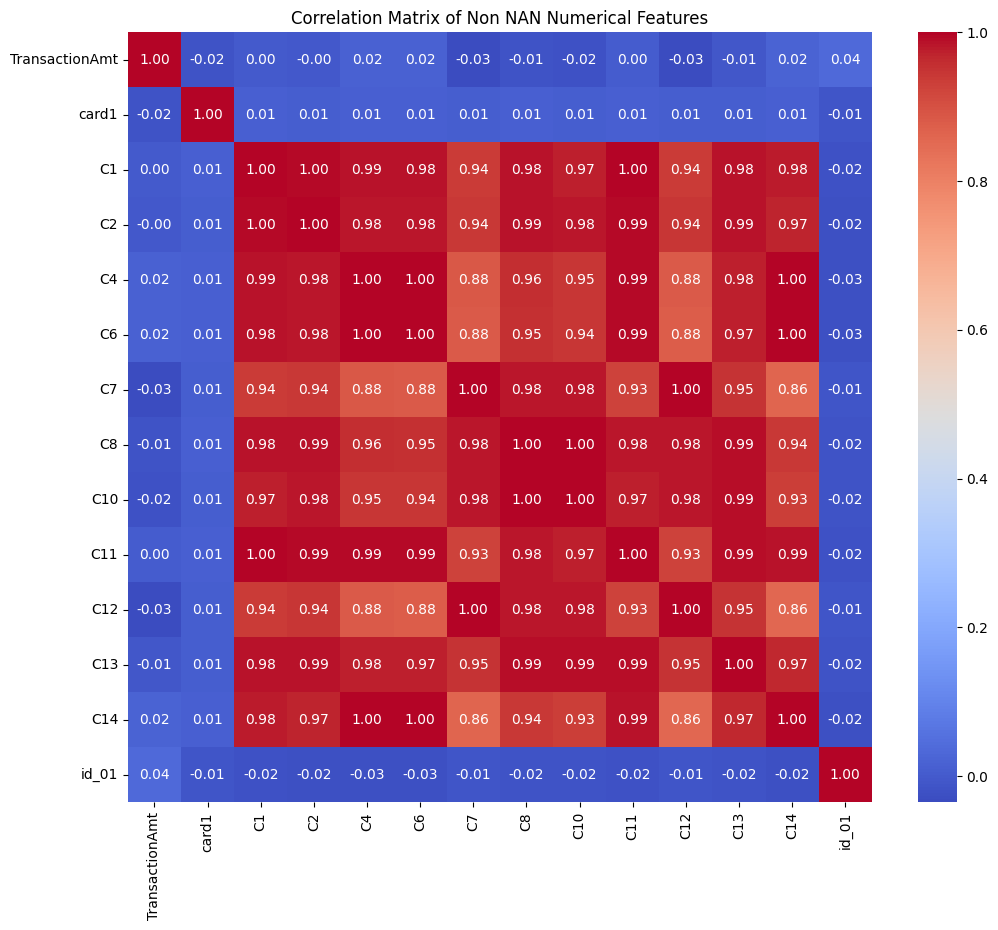

In [17]:
# the we would like to see the correlationship among non nan numerical features
df_corr = df[num_full_col[3:]].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Non NAN Numerical Features')
plt.show()

In [18]:
df_drop_summary = create_summary_table(df_drop)
df_drop_summary.loc[numerical_col_NAN,'Unique values']

,Unique values
card2,482
card3,103
card5,106
D1,641
V167,873
V168,965
V170,49
V171,62
V202,10970
V203,14951


### correlation among numerical_col_nan and numerical_full_col

In [19]:
non_nan_num_col = ['TransactionAmt','card1','C1','id_01']
corr_check ={}
for nan_col in numerical_col_NAN:
    corr_check[nan_col]={}
    for full_col in non_nan_num_col:
        correlation = df_drop[nan_col].corr(df_drop[full_col])
        corr_check[nan_col][full_col] = correlation
avg_corr, max_feature, max_corr = [],[],[]
for i in corr_check.values():
    each_corr_value = list(i.values())
    each_corr_feature = list(i.keys())
    avg_corr.append(sum(each_corr_value)/len(each_corr_value))
    abs_corr = list(map(lambda x: abs(x), each_corr_value))
    max_abs_index = abs_corr.index(max(abs_corr))
    max_feature.append(each_corr_feature[max_abs_index])
    max_corr.append(each_corr_value[max_abs_index])

In [20]:
df_corr_check = pd.DataFrame(list(zip(*[numerical_col_NAN, avg_corr, max_feature, max_corr])),
                             columns=['Nan_Feature', 'Avg_Corr', 'Max_NotNull_Feature', 'Max_Corr_Abs']).sort_values(by='Max_Corr_Abs')
df_corr_check = df_corr_check.reindex(df_corr_check['Max_Corr_Abs'].abs().sort_values(ascending=False).index)
df_corr_check.head()

,Nan_Feature,Avg_Corr,Max_NotNull_Feature,Max_Corr_Abs
48,id_17,-0.109185,TransactionAmt,-0.334971
1,card3,-0.071577,TransactionAmt,-0.256826
46,id_06,0.055615,id_01,0.201637
2,card5,-0.042325,card1,-0.199373
32,V263,0.045591,TransactionAmt,0.156411


#### Deal with Categorical Features

1. KNN：card6, id_16,id_28,id_29,id_35,id_37,id_38,card4, Device Type
3. Simply Fill, id_15->Unknow
4. Need preprocess: P_emaildomain, R_emaildomain,id_31 and Device info

In [21]:
categorical_col_NAN

['card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'id_15',
 'id_16',
 'id_28',
 'id_29',
 'id_31',
 'id_35',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo']

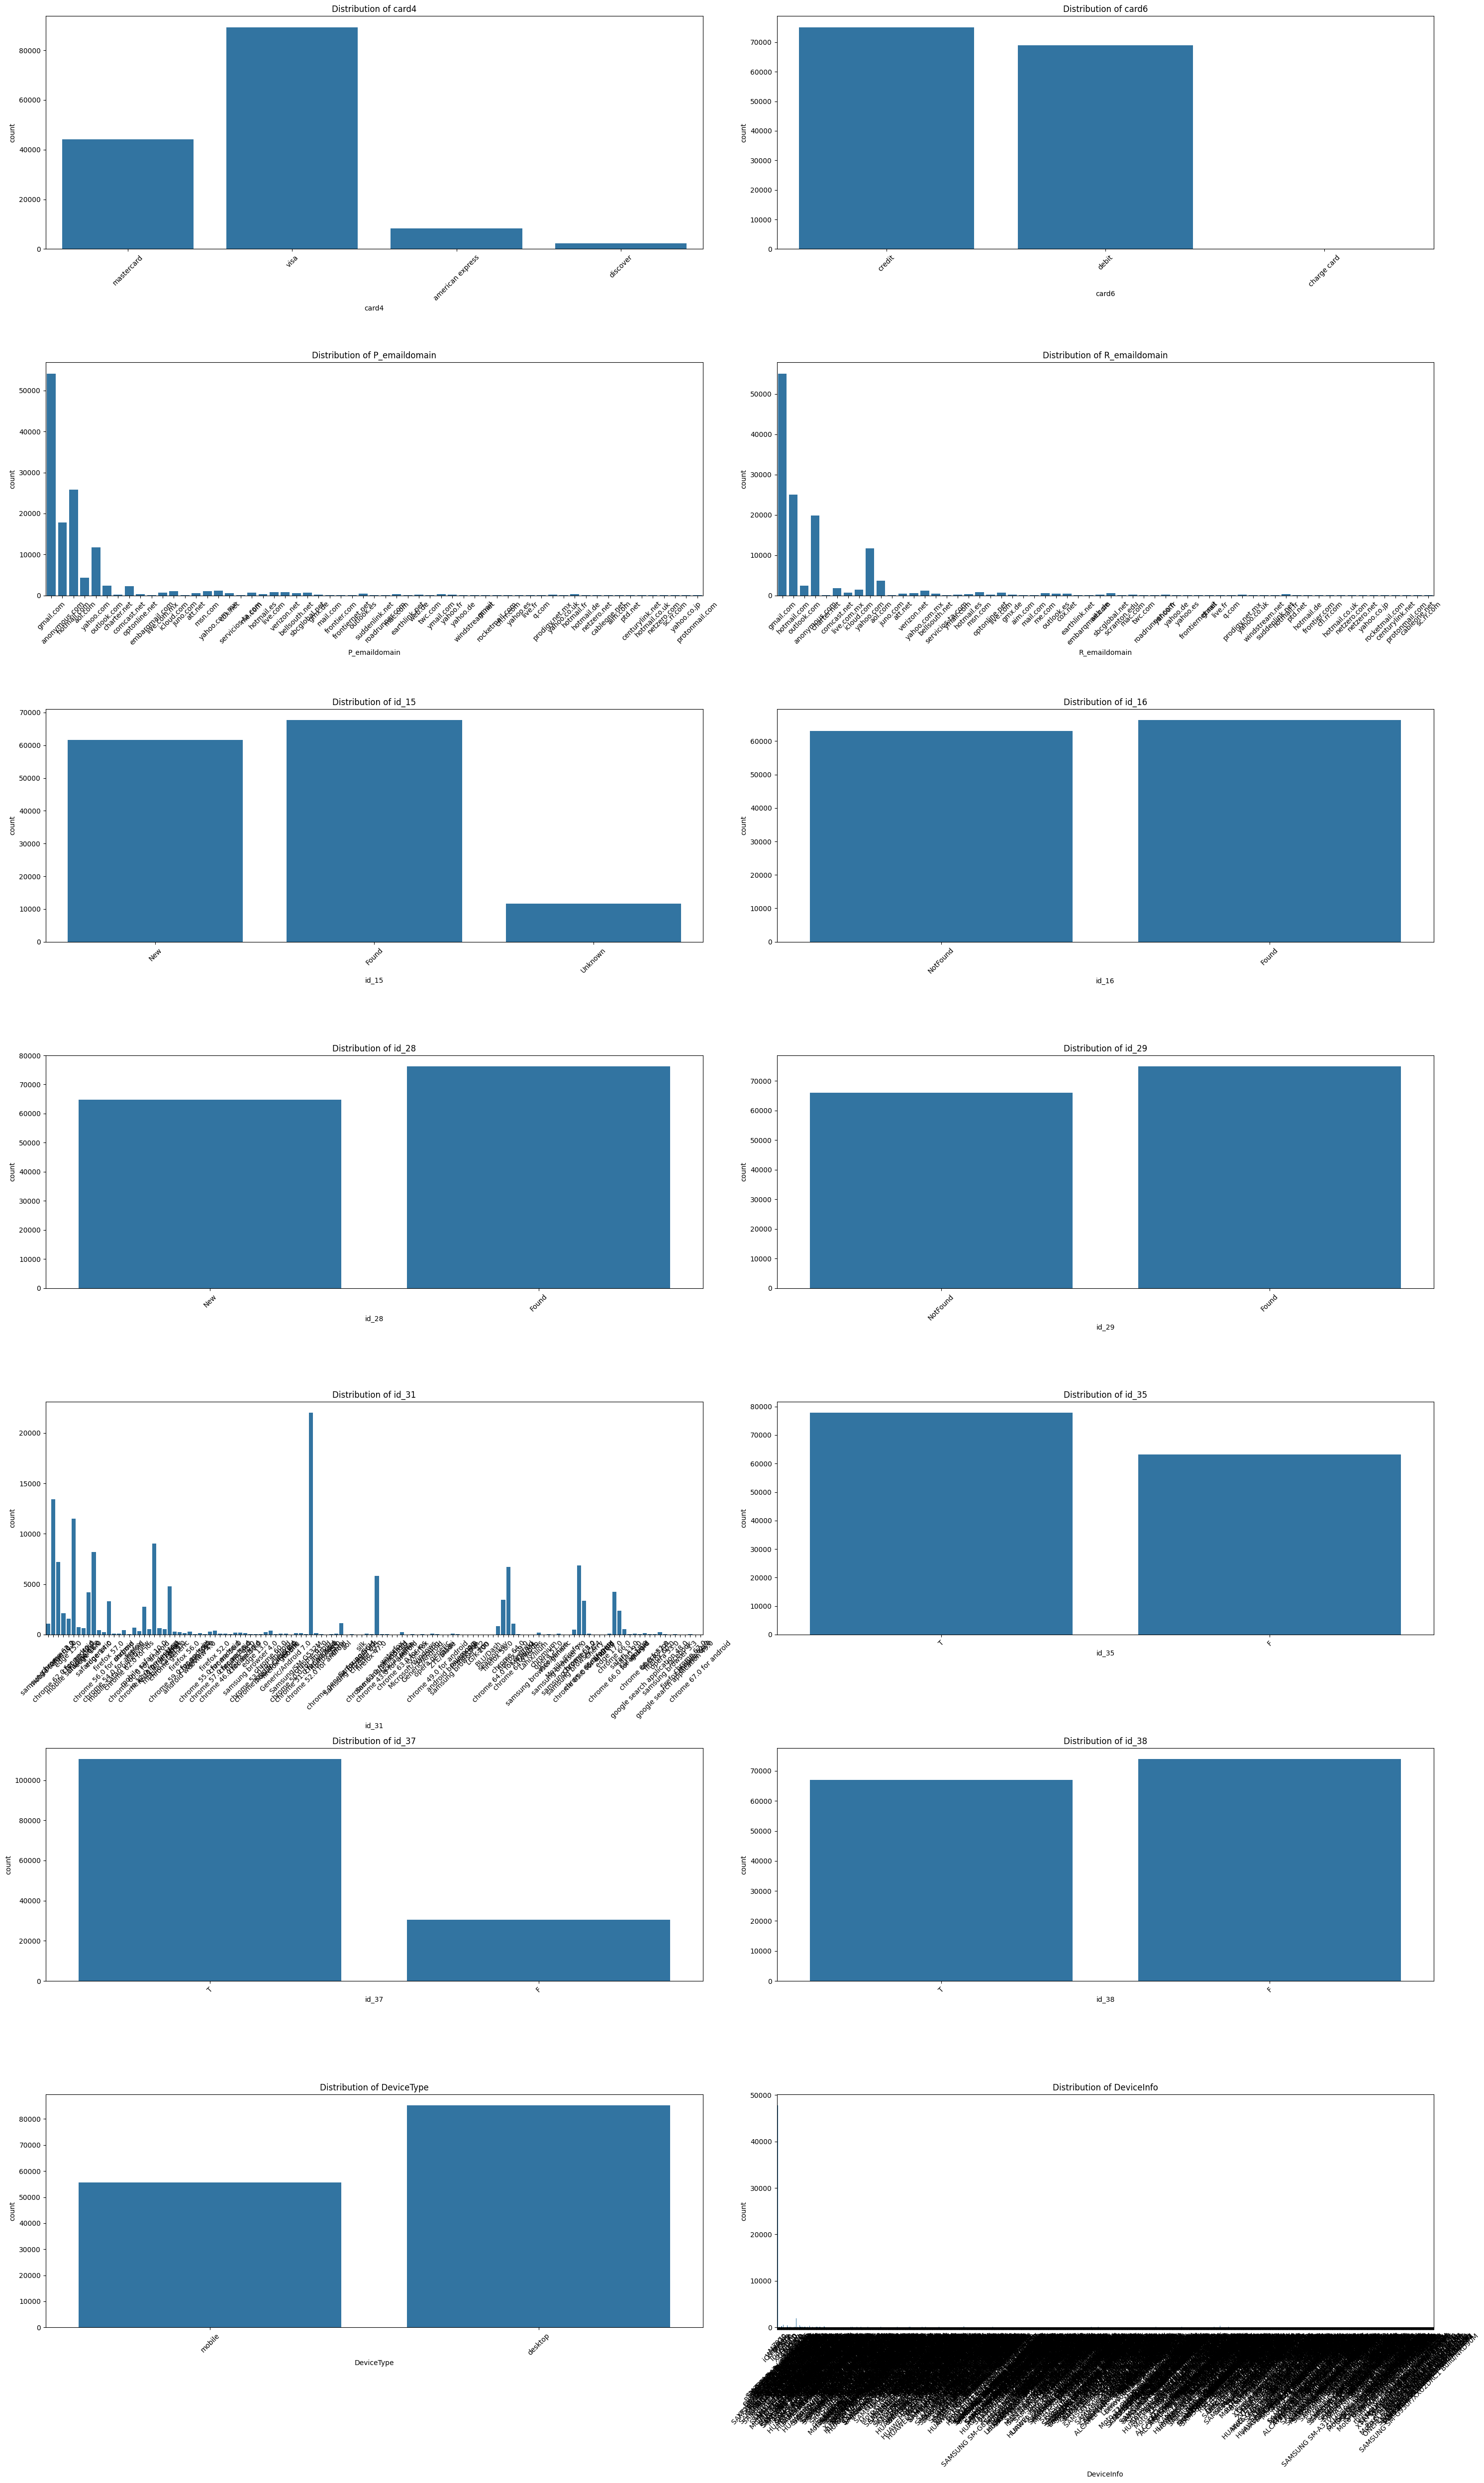

In [22]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(30, 50))
axes = axes.flatten()

# Plot the distribution of each categorical feature
for i, col in enumerate(categorical_col_NAN):
    sns.countplot(data=df_drop, x=col, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [23]:
PCA_list = ['C1', 'C2', 'C4', 'C6', 'C7', 'C8', 'C10', 'C11', 'C12', 'C13', 'C14']
C_X = df_drop.loc[:,PCA_list]
scaler = StandardScaler()
pca = PCA(n_components=1)
pca.fit(scaler.fit_transform(C_X))
C_PCA = pca.transform(C_X)

In [24]:
df_drop = df_drop.copy().drop(columns = PCA_list)
df_drop['C_PCA'] = C_PCA

In [25]:
full_data_col = df_drop.loc[:, df_drop.isnull().sum() == 0].columns.values
categorical_col = df_drop.columns[df_drop.dtypes == 'object']
numerical_col = df_drop.columns[df_drop.dtypes != 'object']

categorical_col_NAN = [col for col in categorical_col if col not in full_data_col]
numerical_col_NAN = [col for col in numerical_col if col not in full_data_col]
numerical_col_FULL = [col for col in numerical_col if col in full_data_col]

##### KNN filling

In [26]:
def fill_na_knn_classifier(df, feature_with_nan, non_nan_features):
    missing_mask = df[feature_with_nan].isna()
    X_train = df.loc[~missing_mask, non_nan_features]
    y_train = df.loc[~missing_mask, feature_with_nan]
    X_test = df.loc[missing_mask, non_nan_features]
    '''print('X_train shape', X_train.shape)
    print('y_train shape', y_train.shape)
    print('X_test shape', X_test.shape)'''
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    # print('finish model train')
    # print('shape of missing', df.loc[missing_mask, feature_with_nan])
    # print('shape of prediction', df.loc[missing_mask, feature_with_nan])
    df.loc[missing_mask, feature_with_nan] = y_pred
    return df


In [27]:
numerical_col_FULL

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'card1',
 'id_01',
 'C_PCA']

In [28]:
knn_filling_freatures = ['card6', 'id_16', 'id_28', 'id_29', 'id_35', 'id_37', 'id_38', 'card4','DeviceType']
new_df = df_drop.copy()
for col in knn_filling_freatures:
    # print('col shape', )
    new_df = fill_na_knn_classifier(new_df, col,numerical_col_FULL)

In [29]:
new_df_summary = create_summary_table(new_df)
new_df_summary.loc[knn_filling_freatures]

,Data Type,# Nonnull records,# Non-zero records,% null records,% non-zero records,Unique values
card6,object,144233,144233,0.0,100.0,3
id_16,object,144233,144233,0.0,100.0,2
id_28,object,144233,144233,0.0,100.0,2
id_29,object,144233,144233,0.0,100.0,2
id_35,object,144233,144233,0.0,100.0,2
id_37,object,144233,144233,0.0,100.0,2
id_38,object,144233,144233,0.0,100.0,2
card4,object,144233,144233,0.0,100.0,4
DeviceType,object,144233,144233,0.0,100.0,2


##### Simple filling

In [30]:
new_df['id_15'].unique()

array(['New', 'Found', nan, 'Unknown'], dtype=object)

In [31]:
new_df['id_15'] = new_df['id_15'].fillna('Unknown')

##### Preprocessing categorical data/ Detect categorical outliers

###### Email Domain Preprocessing

In [32]:
categorical_col_NAN

['card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'id_15',
 'id_16',
 'id_28',
 'id_29',
 'id_31',
 'id_35',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo']

In [33]:
new_df['P_emaildomain'].unique()

array(['gmail.com', 'anonymous.com', 'hotmail.com', 'aol.com',
       'yahoo.com', nan, 'outlook.com', 'charter.net', 'comcast.net',
       'optonline.net', 'embarqmail.com', 'live.com.mx', 'icloud.com',
       'juno.com', 'att.net', 'msn.com', 'yahoo.com.mx', 'cox.net',
       'servicios-ta.com', 'me.com', 'hotmail.es', 'live.com',
       'verizon.net', 'bellsouth.net', 'sbcglobal.net', 'gmx.de',
       'mail.com', 'frontier.com', 'frontiernet.net', 'outlook.es',
       'suddenlink.net', 'roadrunner.com', 'mac.com', 'earthlink.net',
       'web.de', 'twc.com', 'ymail.com', 'yahoo.fr', 'yahoo.de',
       'windstream.net', 'gmail', 'rocketmail.com', 'cfl.rr.com',
       'yahoo.es', 'live.fr', 'q.com', 'prodigy.net.mx', 'yahoo.co.uk',
       'hotmail.fr', 'hotmail.de', 'netzero.net', 'cableone.net',
       'aim.com', 'ptd.net', 'centurylink.net', 'hotmail.co.uk',
       'netzero.com', 'sc.rr.com', 'yahoo.co.jp', 'protonmail.com'],
      dtype=object)

In [34]:
p_emaildomain_counts = df_drop['P_emaildomain'].value_counts(normalize=True)*100
email_counts = {}
for i in p_emaildomain_counts.values:
    email_counts[i//1] = email_counts.get(i//1,0) + 1
l_keys, l_values = [],[]
for k,v in email_counts.items():
    l_keys.append(k)
    l_values.append(v)
df_emailcount = pd.DataFrame({'email %':l_keys, 'Count':l_values})
df_emailcount.sort_values(by='email %',ascending=False)

,email %,Count
0,41.0,1
1,19.0,1
2,13.0,1
3,8.0,1
4,3.0,1
5,1.0,2
6,0.0,52


In [35]:
threshold = 1
# print(p_emaildomain_counts)
p_emaildomain_others = p_emaildomain_counts[p_emaildomain_counts < threshold].index.tolist()
new_df['P_emaildomain'] = df_drop['P_emaildomain'].apply(lambda x: 'others' if x in p_emaildomain_others else x)

In [36]:
r_emaildomain_counts = df_drop['R_emaildomain'].value_counts(normalize=True)*100
email_counts = {}
for i in r_emaildomain_counts.values:
    email_counts[i//1] = email_counts.get(i//1,0) + 1
l_keys, l_values = [],[]
for k,v in email_counts.items():
    l_keys.append(k)
    l_values.append(v)
df_emailcount = pd.DataFrame({'email %':l_keys, 'Count':l_values})
df_emailcount.sort_values(by='email %',ascending=False)

,email %,Count
0,42.0,1
1,19.0,1
2,15.0,1
3,8.0,1
4,2.0,1
5,1.0,3
6,0.0,52


In [37]:
threshold = 1
r_emaildomain_others = r_emaildomain_counts[r_emaildomain_counts < threshold].index.tolist()
new_df['R_emaildomain'] = df_drop['R_emaildomain'].apply(lambda x: 'others' if x in r_emaildomain_others else x)

In [38]:
knn_filling_freatures = ['R_emaildomain','P_emaildomain']
for col in knn_filling_freatures:
    new_df = fill_na_knn_classifier(new_df, col,numerical_col_FULL)

In [39]:
new_df_summary = create_summary_table(new_df)
new_df_summary.loc[knn_filling_freatures]

,Data Type,# Nonnull records,# Non-zero records,% null records,% non-zero records,Unique values
R_emaildomain,object,144233,144233,0.0,100.0,9
P_emaildomain,object,144233,144233,0.0,100.0,8


###### Device Info Preprocessing

In [40]:
unique_device_info = new_df['DeviceInfo'].unique()
'''with open('unique_device_info.txt', 'w') as f:
  for device in unique_device_info:
    f.write(str(device) + '\n')'''
'''new_df.to_csv('Dataset_with_filling_nan_categorical.csv')'''

"new_df.to_csv('Dataset_with_filling_nan_categorical.csv')"

In [41]:
print(len(unique_device_info))

1787


In [42]:
new_df = new_df.drop('DeviceInfo',axis=1)

###### id_31 Browser Type Preprocessing

In [43]:
unique_browser_info = new_df['id_31'].unique()
unique_browser_info

array(['samsung browser 6.2', 'mobile safari 11.0', 'chrome 62.0', nan,
       'chrome 62.0 for android', 'edge 15.0', 'mobile safari generic',
       'chrome 49.0', 'chrome 61.0', 'edge 16.0', 'safari generic',
       'edge 14.0', 'chrome 56.0 for android', 'firefox 57.0',
       'chrome 54.0 for android', 'mobile safari uiwebview', 'chrome',
       'chrome 62.0 for ios', 'firefox', 'chrome 60.0 for android',
       'mobile safari 10.0', 'chrome 61.0 for android',
       'ie 11.0 for desktop', 'ie 11.0 for tablet', 'mobile safari 9.0',
       'chrome generic', 'other', 'chrome 59.0 for android',
       'firefox 56.0', 'android webview 4.0', 'chrome 55.0', 'opera 49.0',
       'ie', 'chrome 55.0 for android', 'firefox 52.0',
       'chrome 57.0 for android', 'chrome 56.0',
       'chrome 46.0 for android', 'chrome 58.0', 'firefox 48.0',
       'chrome 59.0', 'samsung browser 4.0', 'edge 13.0',
       'chrome 53.0 for android', 'chrome 58.0 for android',
       'chrome 60.0', 'mobile sa

In [44]:
browser_type = [
    'chrome','safari','firefox','edge','other', 'samsung','opera','silk','waterfox','Nokia','puffin','Microsoft','cyberfox','ZTE','palemoon','maxthon','line','LG',
    'konqueror','iceweasel','iron','BLU','seamonkey','M4','comodo','Lanix','Inco','Cherry','icedragon','BLU','android'
]

In [45]:
unique_browser_info

array(['samsung browser 6.2', 'mobile safari 11.0', 'chrome 62.0', nan,
       'chrome 62.0 for android', 'edge 15.0', 'mobile safari generic',
       'chrome 49.0', 'chrome 61.0', 'edge 16.0', 'safari generic',
       'edge 14.0', 'chrome 56.0 for android', 'firefox 57.0',
       'chrome 54.0 for android', 'mobile safari uiwebview', 'chrome',
       'chrome 62.0 for ios', 'firefox', 'chrome 60.0 for android',
       'mobile safari 10.0', 'chrome 61.0 for android',
       'ie 11.0 for desktop', 'ie 11.0 for tablet', 'mobile safari 9.0',
       'chrome generic', 'other', 'chrome 59.0 for android',
       'firefox 56.0', 'android webview 4.0', 'chrome 55.0', 'opera 49.0',
       'ie', 'chrome 55.0 for android', 'firefox 52.0',
       'chrome 57.0 for android', 'chrome 56.0',
       'chrome 46.0 for android', 'chrome 58.0', 'firefox 48.0',
       'chrome 59.0', 'samsung browser 4.0', 'edge 13.0',
       'chrome 53.0 for android', 'chrome 58.0 for android',
       'chrome 60.0', 'mobile sa

In [46]:
transfer_map = {}
for browser in unique_browser_info:
    browser_lower = str(browser).lower()
    for keyword in browser_type:
        keyword_lower = keyword.lower()
        if keyword_lower in browser_lower:
            transfer_map[browser] = keyword
            break
        elif 'google' in browser_lower or 'chromium' in browser_lower:
          transfer_map[browser] = 'chrome'
        elif 'ie' in browser_lower:
          transfer_map[browser] = 'edge'
        else:
          transfer_map[browser] = browser

In [47]:
df_drop['id_31'] = df_drop['id_31'].map(transfer_map)
df['id_31'] = df['id_31'].map(transfer_map)

In [48]:
new_df['id_31'] = new_df['id_31'].map(transfer_map)

browser_type_counts = df_drop['id_31'].value_counts(normalize=True)*100
browser_counts = {}
for i in browser_type_counts.values:
    browser_counts[i//1] = browser_counts.get(i//1,0) + 1
l_keys, l_values = [],[]
for k,v in browser_counts.items():
    l_keys.append(k)
    l_values.append(v)
df_browser_type = pd.DataFrame({'browser_type %':l_keys, 'Count':l_values})
df_browser_type.sort_values(by='browser_type %',ascending=False)

,browser_type %,Count
0,54.0,1
1,26.0,1
2,11.0,1
3,5.0,1
4,1.0,1
5,0.0,26


In [49]:
threshold = 1
browser_type_others = browser_type_counts[browser_type_counts < threshold].index.tolist()
new_df['id_31'] = df_drop['id_31'].apply(lambda x: 'others' if x in browser_type_others else x)
new_df = fill_na_knn_classifier(new_df, 'id_31',numerical_col_FULL)

In [50]:
new_df['id_31'].value_counts(normalize=True)*100

,proportion
id_31,
chrome,54.671954
safari,26.325459
edge,11.548675
firefox,4.912884
samsung,1.566909
others,0.974118


#### Deal with Numerical feature

In [51]:
def fill_na_knn_regressor(df, feature_with_nan, non_nan_features):
    missing_mask = df[feature_with_nan].isna()
    X_train = df.loc[~missing_mask, non_nan_features]
    y_train = df.loc[~missing_mask, feature_with_nan]
    X_test = df.loc[missing_mask, non_nan_features]
    knn = KNeighborsRegressor(n_neighbors=3)
    knn.fit(X_train, y_train)
    df.loc[missing_mask, feature_with_nan] = knn.predict(X_test)
    return df
for feature in numerical_col_NAN:
    if df[feature].isna().sum() > 0:
        new_df2 = fill_na_knn_regressor(new_df, feature,numerical_col_FULL)


In [52]:
new_df2_summary = create_summary_table(new_df2)
new_df2_summary.loc[numerical_col_NAN]

,Data Type,# Nonnull records,# Non-zero records,% null records,% non-zero records,Unique values
card2,float64,144233,144233,0.0,100.00,777
card3,float64,144233,144233,0.0,100.00,111
card5,float64,144233,144233,0.0,100.00,230
D1,float64,144233,29785,0.0,20.65,691
V167,float64,144233,35261,0.0,24.45,895
V168,float64,144233,40086,0.0,27.79,1000
V170,float64,144233,134539,0.0,93.28,70
V171,float64,144233,134653,0.0,93.36,88
V202,float64,144233,35261,0.0,24.45,11609
V203,float64,144233,43807,0.0,30.37,15892


In [53]:
numerical_col_NAN = [col for col in numerical_col if col != 'isFraud']

In [54]:
# before delete z-score detected outliers
df_drop['isFraud'].value_counts(dropna=False, normalize = True)

,proportion
isFraud,
0,0.92153
1,0.07847


In [55]:
numerical_col = new_df2.columns[new_df2.dtypes != 'object']
new_column = [col for col in numerical_col if col != 'isFraud']
for i in range(len(new_column)):
    col = new_column[i]
    for j in range(i+1,len(new_column)):
        col2 = new_column[j]
        corr = new_df2[col].corr(new_df2[col2])
        if corr > 0.9:
            print(f'Correlation between {col} and {col2}: {corr}')

Correlation between TransactionID and TransactionDT: 0.9982919237633693
Correlation between V167 and V168: 0.9403155725399582
Correlation between V167 and V202: 0.9889695672183466
Correlation between V167 and V204: 0.9122430122887961
Correlation between V167 and V280: 0.9262054691019223
Correlation between V167 and V307: 0.9325372746754211
Correlation between V167 and V308: 0.9237395506741104
Correlation between V168 and V202: 0.9339404594062002
Correlation between V168 and V203: 0.9205774691908316
Correlation between V168 and V204: 0.9807514819710473
Correlation between V168 and V280: 0.9777382317239489
Correlation between V168 and V307: 0.9662918528870721
Correlation between V168 and V308: 0.9708033318260942
Correlation between V202 and V204: 0.926847665057002
Correlation between V202 and V280: 0.9159968443950252
Correlation between V202 and V307: 0.9341854856399607
Correlation between V202 and V308: 0.9278000745439561
Correlation between V203 and V204: 0.9643290600035088
Correlation

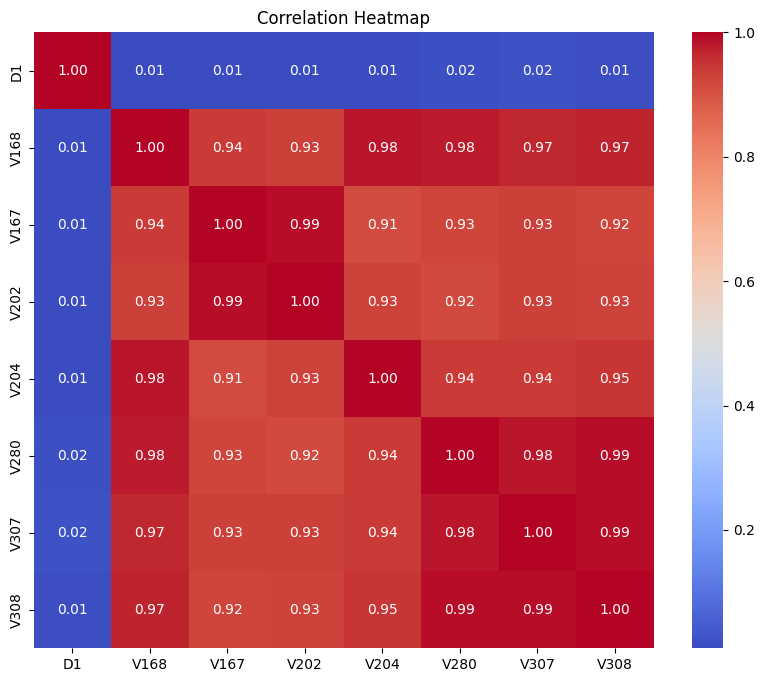

In [56]:

cols_to_plot = ['D1','V168', 'V167', 'V202', 'V204', 'V280', 'V307', 'V308']

# Check if all columns exist in the DataFrame
if not all(col in new_df2.columns for col in cols_to_plot):
    missing_cols = set(cols_to_plot) - set(new_df2.columns)
    print(f"Warning: The following columns are not present in the DataFrame: {missing_cols}")
    # Remove missing columns from the list
    cols_to_plot = [col for col in cols_to_plot if col in new_df2.columns]
correlation_matrix = new_df2[cols_to_plot].corr()

plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [57]:
new_PCA_list = ['V168', 'V167', 'V202', 'V204', 'V280', 'V307', 'V308']
V_X = new_df2.loc[:,new_PCA_list]
scaler = StandardScaler()
pca = PCA(n_components=1)
pca.fit(scaler.fit_transform(V_X))
V_PCA = pca.transform(V_X)

In [58]:
df_drop = df_drop.copy().drop(columns = new_PCA_list)
new_df2 = new_df2.copy().drop(columns = new_PCA_list)
df_drop['V_PCA'] = V_PCA
new_df2['V_PCA'] = V_PCA

In [59]:
new_df2.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'P_emaildomain', 'R_emaildomain', 'D1', 'V170', 'V171', 'V203', 'V217',
       'V218', 'V219', 'V221', 'V222', 'V224', 'V228', 'V229', 'V230', 'V231',
       'V232', 'V233', 'V245', 'V250', 'V251', 'V255', 'V256', 'V258', 'V259',
       'V261', 'V262', 'V263', 'V264', 'V265', 'V267', 'V273', 'V274', 'V275',
       'V282', 'V283', 'id_01', 'id_02', 'id_05', 'id_06', 'id_13', 'id_15',
       'id_16', 'id_17', 'id_19', 'id_20', 'id_28', 'id_29', 'id_31', 'id_35',
       'id_37', 'id_38', 'DeviceType', 'C_PCA', 'V_PCA'],
      dtype='object')

In [60]:
new_df2.to_csv('Dataset_with_filling_nan.csv')

## Outerlier detection

#### IQR detects outliers

In [71]:
def find_outlier_indices(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_indices = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)].index
    return outlier_indices


In [72]:
def draw_outlier_boxplot(df, feature):
    fig, ax = plt.subplots(figsize=(6, 20))
    ax.boxplot(x=df[feature])
    ax.set_title(f'Box Plot of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Value')
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_indices = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)].index
    outliers = df.loc[outlier_indices, feature]
    # ax.scatter(outliers.index, outliers, color='red', label='Outliers')
    ax.legend()
    plt.show()


In [73]:
outliers_map = {}
numerical_col = new_df2.columns[new_df2.dtypes != 'object']
numerical_col_NAN = [col for col in numerical_col if col != 'isFraud']

for col in numerical_col_NAN:
    outliers = find_outlier_indices(new_df2, col)
    outliers_map[col] = outliers
    # print(f'Number of outliers in {col}: {len(outliers)}')

In [74]:
new_df2.shape[0]

144233

In [75]:
for k,v in outliers_map.items():
    if v.shape[0] > 0:
        print(f'Number of outliers in {k}: {len(v)/144233}')
        # draw_outlier_boxplot(new_df2, k)

Number of outliers in TransactionAmt: 0.060014005116720864
Number of outliers in D1: 0.20650613937171106
Number of outliers in V170: 0.28036579700900627
Number of outliers in V171: 0.314095941982764
Number of outliers in V203: 0.180541207629322
Number of outliers in V217: 0.2401392191800767
Number of outliers in V218: 0.11216573183668092
Number of outliers in V219: 0.0905548660847379
Number of outliers in V221: 0.4198831058079635
Number of outliers in V222: 0.43673084522959377
Number of outliers in V224: 0.15760609569238662
Number of outliers in V228: 0.1625286862229864
Number of outliers in V229: 0.22428986431676523
Number of outliers in V230: 0.19057358579520636
Number of outliers in V231: 0.14638813586349864
Number of outliers in V232: 0.16665395575215103
Number of outliers in V233: 0.15606691949831175
Number of outliers in V245: 0.27604639714905743
Number of outliers in V250: 0.24505487648457705
Number of outliers in V251: 0.24826496016861607
Number of outliers in V255: 0.246774316

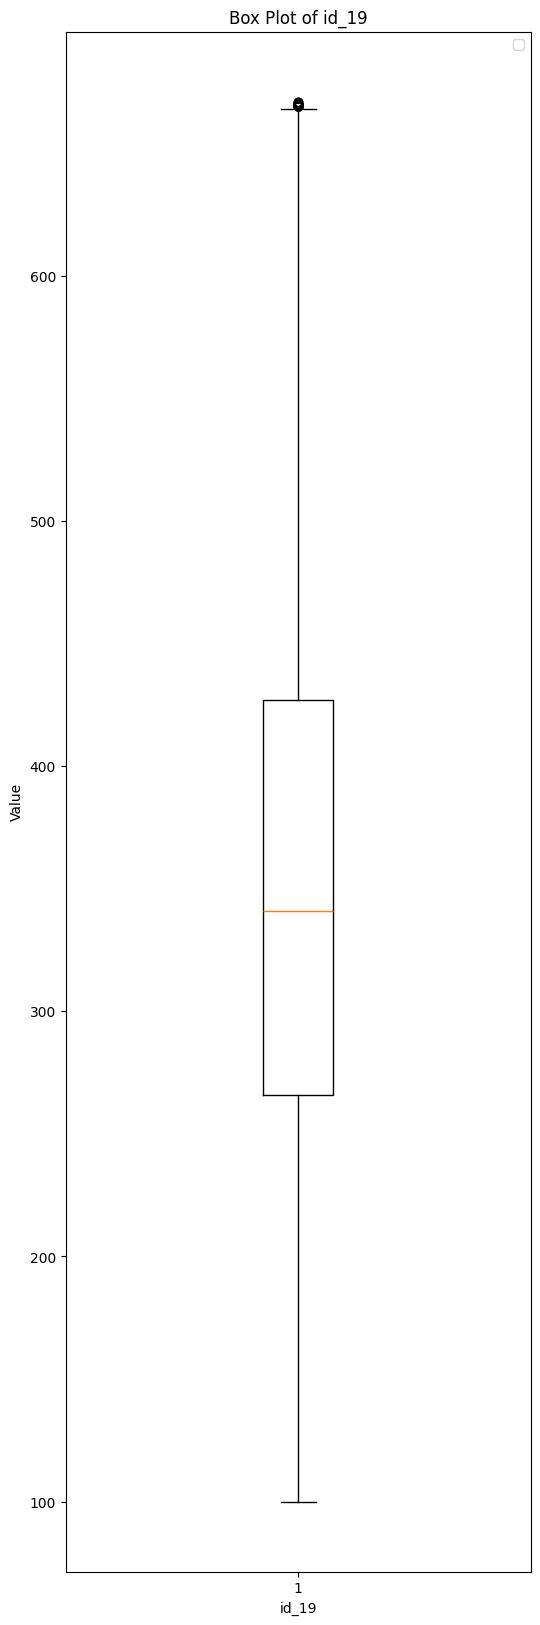

In [76]:
draw_outlier_boxplot(new_df2, 'id_19')

### Z-score outlier detection

In [77]:
def detect_outliers_zscore(df, feature, threshold=3):
  z_scores = np.abs((df[feature] - df[feature].mean()) / df[feature].std())
  outlier_indices = df[z_scores > threshold].index
  return outlier_indices

outliers_zscore_map = {}
for col in numerical_col_NAN:
    outliers_zscore = detect_outliers_zscore(new_df2, col)
    outliers_zscore_map[col] = outliers_zscore
    # print(f'Number of outliers in {col}: {len(outliers_zscore)}')

for k,v in outliers_zscore_map.items():
    if v.shape[0] > 0:
        print(f'Number of outliers in {k} using Z-score: {len(v)/144233}')


Number of outliers in TransactionAmt using Z-score: 0.018768243051174142
Number of outliers in card3 using Z-score: 0.005726844758134408
Number of outliers in D1 using Z-score: 0.04227881275436273
Number of outliers in V170 using Z-score: 0.01554429291493625
Number of outliers in V171 using Z-score: 0.02262311676246074
Number of outliers in V203 using Z-score: 0.011883549534433867
Number of outliers in V217 using Z-score: 0.0025444939784931325
Number of outliers in V218 using Z-score: 0.0037439420936956173
Number of outliers in V219 using Z-score: 0.0031892840057407114
Number of outliers in V221 using Z-score: 0.0075433499961867255
Number of outliers in V222 using Z-score: 0.00779987936186587
Number of outliers in V224 using Z-score: 0.00628843607218875
Number of outliers in V228 using Z-score: 0.01586322131551032
Number of outliers in V229 using Z-score: 0.00560897991444399
Number of outliers in V230 using Z-score: 0.011987547925925412
Number of outliers in V231 using Z-score: 0.00255

In [78]:
outliers_index_list = []
for col in numerical_col_NAN:
    outliers_zscore = detect_outliers_zscore(new_df2, col)
    outliers_zscore_map[col] = outliers_zscore
    outliers_index_list.extend(outliers_zscore)
unique_outlier_index = set(outliers_index_list)

In [79]:
new_df3 = new_df2.drop(list(unique_outlier_index))

In [80]:
# after delete z-score detected outliers
new_df3['isFraud'].value_counts(dropna=False, normalize = True)

,proportion
isFraud,
0,0.938582
1,0.061418


### Isolation Forest

In [81]:
normal_transactions = new_df2[new_df2['isFraud'] == 0]
features = [col for col in new_df2.columns if col != 'isFraud' and new_df2[col].dtype != 'object']


model = IsolationForest(contamination=0.1)
model.fit(normal_transactions[features])


outlier_scores = model.decision_function(normal_transactions[features])
normal_transactions['outlier_score'] = outlier_scores

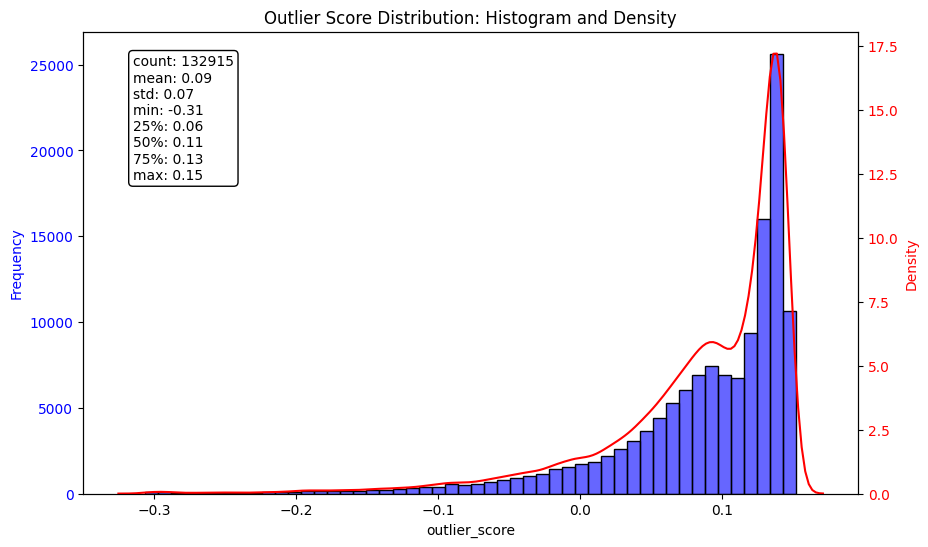

In [92]:
fig, ax1 = plt.subplots(figsize=(10, 6))
stats = normal_transactions['outlier_score'].describe()
stats_text = '\n'.join([
    f"count: {stats['count']:.0f}",
    f"mean: {stats['mean']:.2f}",
    f"std: {stats['std']:.2f}",
    f"min: {stats['min']:.2f}",
    f"25%: {stats['25%']:.2f}",
    f"50%: {stats['50%']:.2f}",
    f"75%: {stats['75%']:.2f}",
    f"max: {stats['max']:.2f}"
])

sns.histplot(
    normal_transactions['outlier_score'],
    bins=50,
    color='blue',
    alpha=0.6,
    ax=ax1
)
ax1.set_ylabel('Frequency', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
sns.kdeplot(
    normal_transactions['outlier_score'],
    color='red',
    ax=ax2
)
ax2.set_ylabel('Density', color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.title('Outlier Score Distribution: Histogram and Density')
plt.xlabel('Outlier Score')
plt.text(
    x=plt.xlim()[0]*0.9,
    y=plt.ylim()[1] * 0.95,
    s=stats_text,
    fontsize=10,
    color='black',
    verticalalignment='top',
    bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white')
)
plt.show()

In [97]:
outlier_target_score = 0.09 - 3* 0.07
outliers = normal_transactions[normal_transactions['outlier_score'] < outlier_target_score]
print(len(outliers))

2359


In [100]:
new_df2 = new_df2.drop(outliers.index) # Removing outliers from new_df2

## Encoding Categorical data

### Catboost Encoding

In [101]:
new_categorical = new_df2.columns[new_df2.dtypes == 'object']
catboost_encoder = CatBoostEncoder()
encode = catboost_encoder.fit_transform(new_df2[new_categorical], new_df2['isFraud'])
df_cat = new_df2.copy()
df_cat[new_categorical] = encode

### Onehot Encoding

In [102]:
df_onehot = pd.get_dummies(new_df2, columns=new_categorical, dummy_na=False)

# Model Training

### Help function

In [103]:
def X_y_train_test(df):
    X = df.sort_values('TransactionDT').drop((['isFraud', 'TransactionDT', 'TransactionID']), axis=1)
    y = list(df.sort_values('TransactionDT')['isFraud'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_scaled_train = scaler.fit_transform(X_train)
    X_scaled_test = scaler.fit_transform(X_test)
    return (X_scaled_train, X_scaled_test, y_train, y_test)

In [121]:
def show_performance(y_test, y_pred):
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()


    specificity = tn / (tn + fp)
    print(f"Specificity: {specificity:.2f}")
    print("Sensitivity:", recall)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("F1-score:", f1)
    print("MCC:", matthews_corrcoef(y_test, y_pred))

    print('')

    precision_l, recall_l, thresholds = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_l, precision_l)

    print("AUC-ROC:", roc_auc_score(y_test, y_pred))
    print("AUC-PR:", pr_auc)
    return specificity, recall, accuracy, precision, f1, matthews_corrcoef(y_test, y_pred), roc_auc_score(y_test, y_pred), pr_auc

In [174]:
def visual_performance(y_test, y_pred, y_pred_proba):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(3, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    if y_pred_proba is not None:

        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)

        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    else:
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_pred)

        precision, recall, _ = precision_recall_curve(y_test, y_pred)

    pr_auc = auc(recall, precision)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', lw=2)
    axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate (FPR)')
    axes[0].set_ylabel('True Positive Rate (TPR)')
    axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    axes[0].legend(loc='lower right')
    axes[0].grid(alpha=0.3)

    axes[1].plot(recall, precision, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})', lw=2)
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_title('Precision-Recall Curve')
    axes[1].legend(loc='lower left')
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

In [106]:
def show_parameter_scores(search_model):
    results = search_model.cv_results_
    scores_df = pd.DataFrame({
        'params': results['params'],
        'mean_test_score': results['mean_test_score'],
        'std_test_score': results['std_test_score'],
        'rank_test_score': results['rank_test_score']
    })
    scores_df = scores_df.sort_values(by='rank_test_score')
    return scores_df

In [107]:
def draw_parameter_scores(scores_df):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(scores_df)), scores_df['mean_test_score'], tick_label=scores_df['params'], align='center')
    plt.xticks(rotation=90)
    plt.ylabel('Mean Test Score')
    plt.xlabel('Parameter Set')
    plt.title('Scores for Parameter Sets in HalvingGridSearchCV')
    plt.tight_layout()
    plt.show()


In [108]:
def extract_and_plot_parameter_distributions(scores_df, top_n=100):
  param_values = [params for params in scores_df['params'].iloc[:top_n]]
  param_dict = {}
  for params in param_values:
      for key, value in params.items():
          if key not in param_dict:
              param_dict[key] = []
          param_dict[key].append(value)
  for param_name, values in param_dict.items():
      plt.figure(figsize=(8, 6))
      sns.histplot(values)
      plt.title(f'Distribution of {param_name}')
      plt.xlabel(param_name)
      plt.ylabel('Frequency')
      plt.show()



In [109]:
def draw_3d_plot(score_df, parameter_col, target_col):
    grouped_df = score_df.groupby(parameter_col, as_index=False)[target_col].mean()
    X = grouped_df[parameter_col[0]]
    Y = grouped_df[parameter_col[1]]
    Z = grouped_df[parameter_col[2]]
    T = grouped_df[target_col]
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X, Y, Z, c=T, cmap='viridis', s=100)
    ax.set_xlabel(parameter_col[0].replace('sgd__', ''))
    ax.set_ylabel(parameter_col[1].replace('sgd__', ''))
    ax.set_zlabel(parameter_col[2].replace('sgd__', ''))
    ax.set_title('3D Plot of Mean Test Score')
    cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
    cbar.set_label('Mean Test Score', rotation=270, labelpad=15)
    plt.show()

In [110]:
para_model = {}

In [111]:
model_performance = {}

### Data Oversampling

In [112]:
oversample = SMOTE()
X = df_cat.drop('isFraud', axis=1)
y = df_cat['isFraud']
X_resampled, y_resampled = oversample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

### SVM

In [113]:
param_svm = {
    'pca__n_components': [5, 10, 15, 20, 25],
    'sgd__alpha': [0.0001, 0.001, 0.01,0.005, 0.0005],
    'sgd__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'sgd__max_iter': [500, 1000, 2000, 3000],
    'sgd__eta0': [0.001, 0.01, 0.1],
    'sgd__tol': [0.0001, 0.001, 0.01]
}
pipeline = Pipeline([
    ('pca', PCA()),
    ('sgd', SGDClassifier(random_state=42, penalty='elasticnet', loss='hinge'))
])

###### RandomSearch

In [114]:
random_search = RandomizedSearchCV(pipeline, param_svm, n_iter=10, cv=5, scoring='recall', random_state=42)
random_search.fit(X_train, y_train)
print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)
best_sgd_classifier = random_search.best_estimator_
y_pred = best_sgd_classifier.predict(X_test)
y_pred_proba = best_sgd_classifier.decision_function(X_test)
para_model['svm_rm_classifier'] = best_sgd_classifier
joblib.dump(best_sgd_classifier, 'svm_model.pkl')

Best Hyperparameters: {'sgd__tol': 0.0001, 'sgd__max_iter': 1000, 'sgd__learning_rate': 'adaptive', 'sgd__eta0': 0.01, 'sgd__alpha': 0.01, 'pca__n_components': 10}
Best Score: 0.6437886133360076


['svm_model.pkl']

In [122]:
specificity, recall, accuracy, precision, f1, mcc, roc_auc, pr_auc = show_performance(y_test, y_pred)
model_performance['svm_rm_classifier'] = [specificity, recall, accuracy, precision, f1, mcc, roc_auc, pr_auc]

Specificity: 0.75
Sensitivity: 0.6785687210977182
Accuracy: 0.7156042356815963
Precision: 0.7374969102743676
F1-score: 0.7068066961465572
MCC: 0.4330342054055609

AUC-ROC: 0.7159919183059119
AUC-PR: 0.7892230958308067


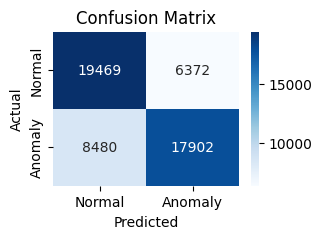

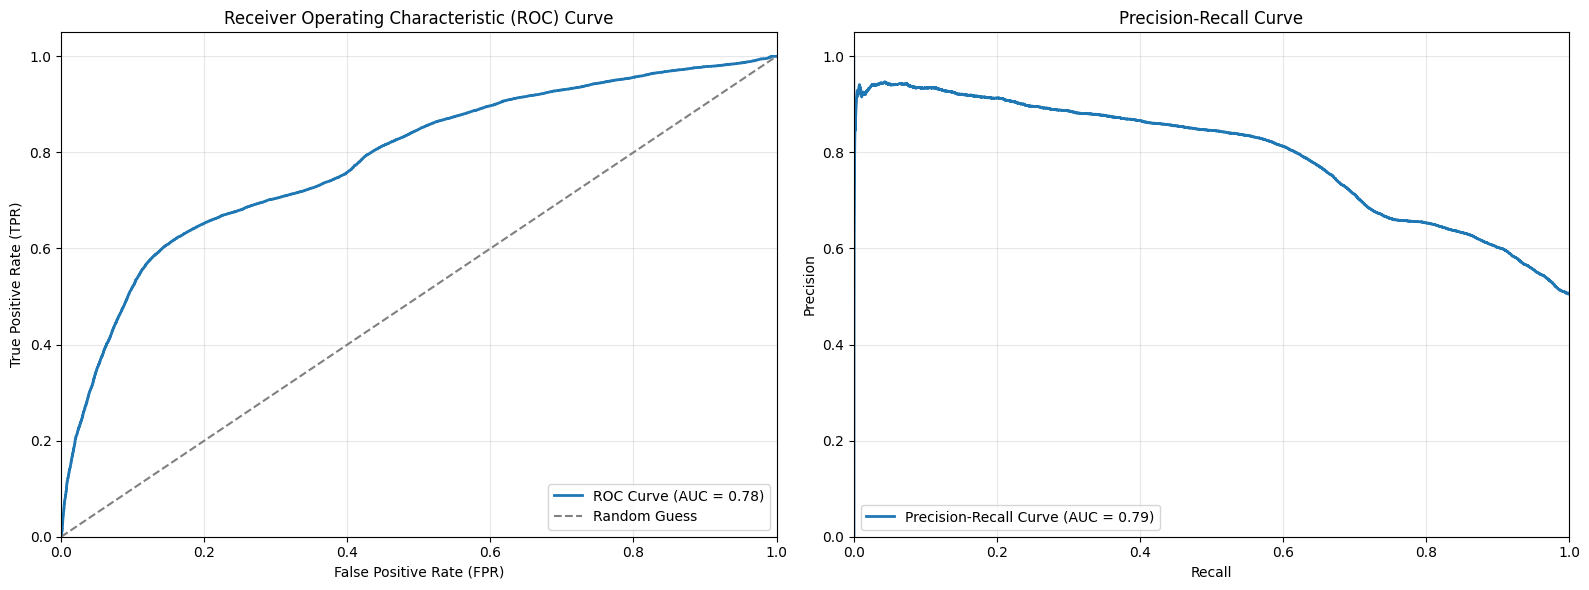

In [123]:
visual_performance(y_test, y_pred, y_pred_proba)

### LightGBM

In [124]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
param_lgm = {
    'pca__n_components': [10, 20, 30],
    'lgbm__num_leaves': [31, 50, 80],
    'lgbm__n_estimators': [150, 200],
    'lgbm__min_child_samples': [5, 10],
    'lgbm__max_depth': [-1, 10, 20],
    'lgbm__learning_rate': [0.1, 0.2],
    'lgbm__feature_fraction': [1.0, 0.8],
    'lgbm__bagging_freq': [5, 10],
    'lgbm__bagging_fraction': [1.0, 0.8],
    'lgbm__verbose': [-1],  # Set to -1 to suppress warnings
}
pipeline = Pipeline([
    ('pca', PCA()),
    ('lgbm', lgb.LGBMClassifier())
])

#### Random Search

Best Hyperparameters: {'pca__n_components': 30, 'lgbm__verbose': -1, 'lgbm__num_leaves': 50, 'lgbm__n_estimators': 200, 'lgbm__min_child_samples': 10, 'lgbm__max_depth': 20, 'lgbm__learning_rate': 0.2, 'lgbm__feature_fraction': 0.8, 'lgbm__bagging_freq': 10, 'lgbm__bagging_fraction': 1.0}
Best Score: 0.988859938883974
Specificity: 0.95
Sensitivity: 0.9456068531574559
Accuracy: 0.9476284395764318
Precision: 0.9504705299653293
F1-score: 0.9480324535902259
MCC: 0.895263214767204

AUC-ROC: 0.9476496012623702
AUC-PR: 0.9617778486377766


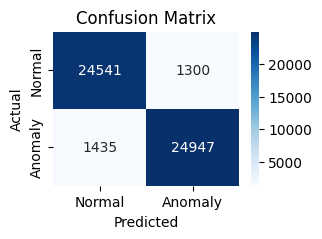

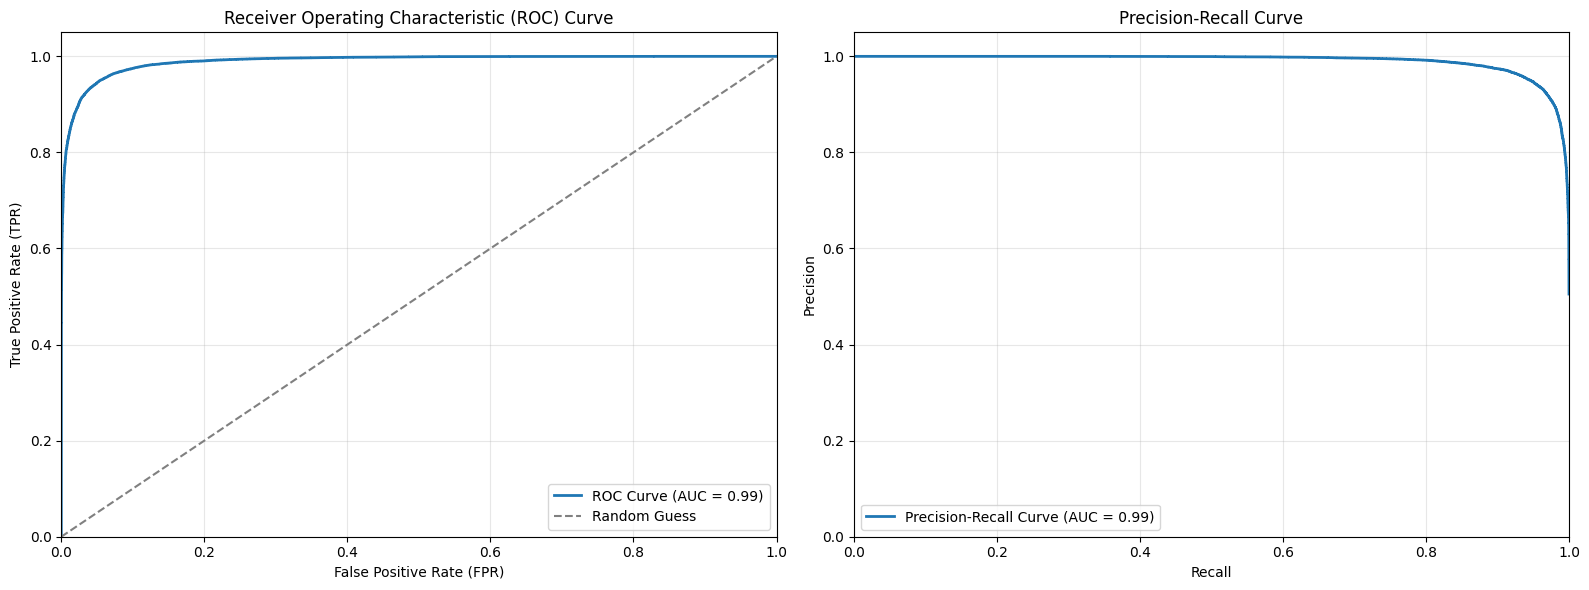

In [126]:
random_search = RandomizedSearchCV(pipeline, param_lgm, n_iter=10, cv=5, scoring='average_precision', random_state=42)
random_search.fit(X_train,y_train)
print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)
best_lgbm_classifier = random_search.best_estimator_
y_pred = best_lgbm_classifier.predict(X_test)
para_model['lgbm_rm_classifier'] = best_lgbm_classifier
joblib.dump(best_lgbm_classifier, 'lgbm_model.pkl')
y_pred_proba = best_lgbm_classifier.predict_proba(X_test)[:, 1]
specificity, recall, accuracy, precision, f1, mcc, roc_auc, pr_auc = show_performance(y_test, y_pred)
model_performance['lgbm_rm_classifier'] = [specificity,recall, accuracy, precision, f1, mcc, roc_auc, pr_auc]
visual_performance(y_test, y_pred, y_pred_proba)


#### Halving Grid Search

In [145]:
halving_search = HalvingGridSearchCV(
    pipeline,
    param_grid=param_lgm,
    cv=5,
    scoring='average_precision',
    random_state=42,
    factor=2,
    resource='n_samples'
)
halving_search.fit(X_train, y_train)

HalvingGridSearchCV(estimator=Pipeline(steps=[('pca', PCA()),
                                              ('lgbm', LGBMClassifier())]),
                    factor=2,
                    param_grid={'lgbm__bagging_fraction': [1.0, 0.8],
                                'lgbm__bagging_freq': [5, 10],
                                'lgbm__feature_fraction': [1.0, 0.8],
                                'lgbm__learning_rate': [0.1, 0.2],
                                'lgbm__max_depth': [-1, 10, 20],
                                'lgbm__min_child_samples': [5, 10],
                                'lgbm__n_estimators': [150, 200],
                                'lgbm__num_leaves': [31, 50, 80],
                                'lgbm__verbose': [-1],
                                'pca__n_components': [10, 20, 30]},
                    random_state=42, scoring='average_precision')

In [147]:
print("Best Hyperparameters:", halving_search.best_params_)
print("Best Score:", halving_search.best_score_)
best_lgbm_classifier = halving_search.best_estimator_
y_pred = best_lgbm_classifier.predict(X_test)
joblib.dump(best_lgbm_classifier, 'lgbm_model.pkl')
para_model['LGBM_halving'] = best_lgbm_classifier
y_pred_proba = best_lgbm_classifier.predict_proba(X_test)[:, 1]
specificity, recall, accuracy, precision, f1, mcc, roc_auc, pr_auc = show_performance(y_test, y_pred)
model_performance['lgbm_rm_classifier'] = [specificity,recall, accuracy, precision, f1, mcc, roc_auc, pr_auc]

Best Hyperparameters: {'lgbm__bagging_fraction': 0.8, 'lgbm__bagging_freq': 5, 'lgbm__feature_fraction': 1.0, 'lgbm__learning_rate': 0.2, 'lgbm__max_depth': 20, 'lgbm__min_child_samples': 10, 'lgbm__n_estimators': 200, 'lgbm__num_leaves': 80, 'lgbm__verbose': -1, 'pca__n_components': 30}
Best Score: 0.9871605253838875
Specificity: 0.94
Sensitivity: 0.9452726784961484
Accuracy: 0.943511479616261
Precision: 0.9418795585595906
F1-score: 0.9435730680948737
MCC: 0.8870289384470604

AUC-ROC: 0.943512726542372
AUC-PR: 0.9572482553258321


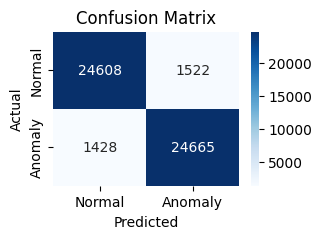

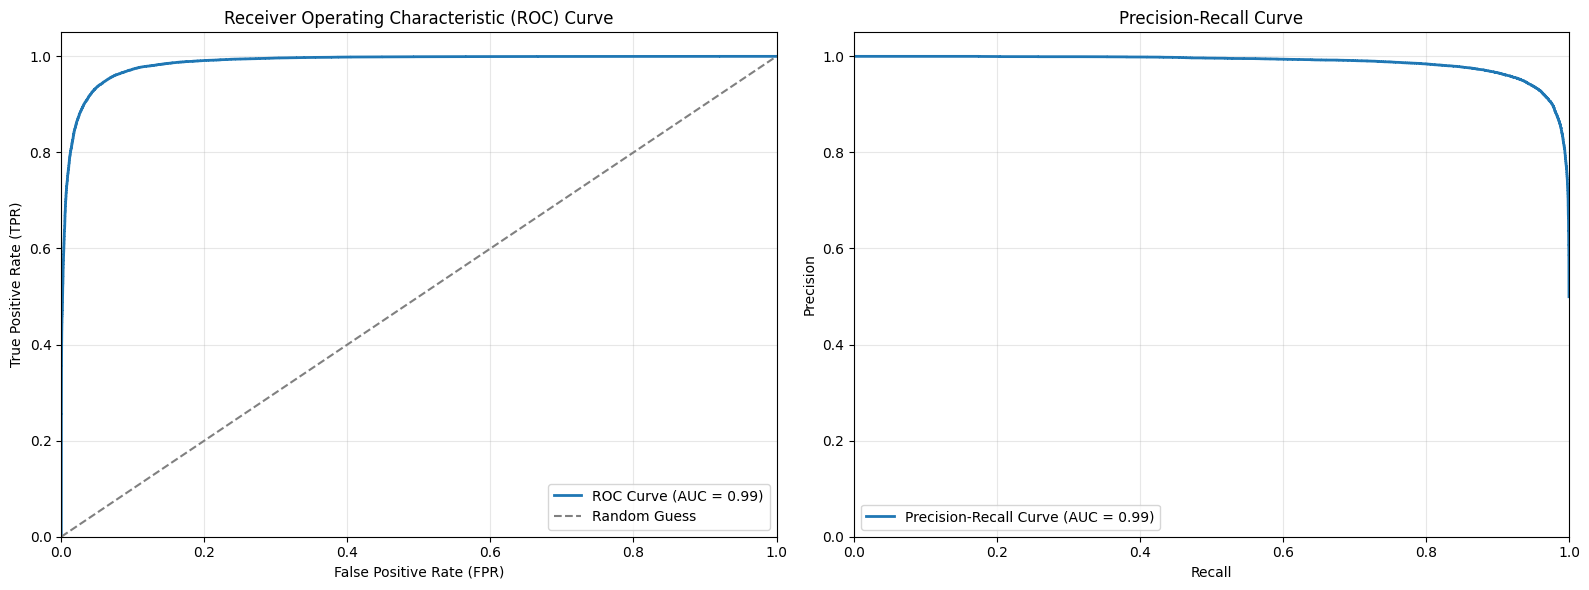

In [148]:
visual_performance(y_test, y_pred, y_pred_proba)

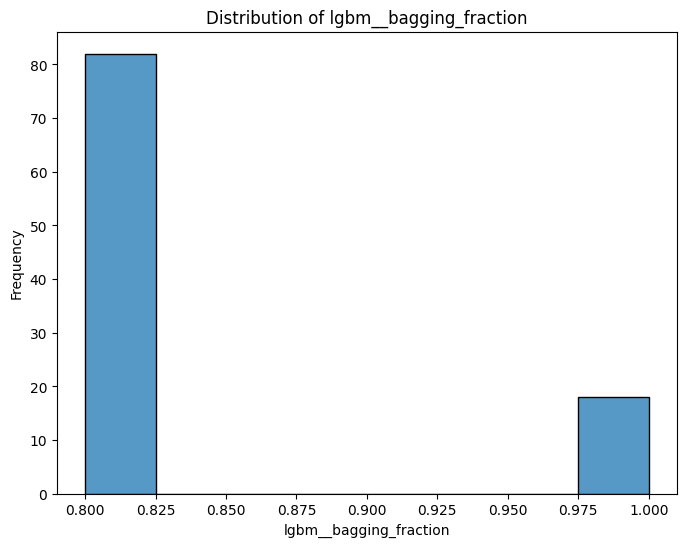

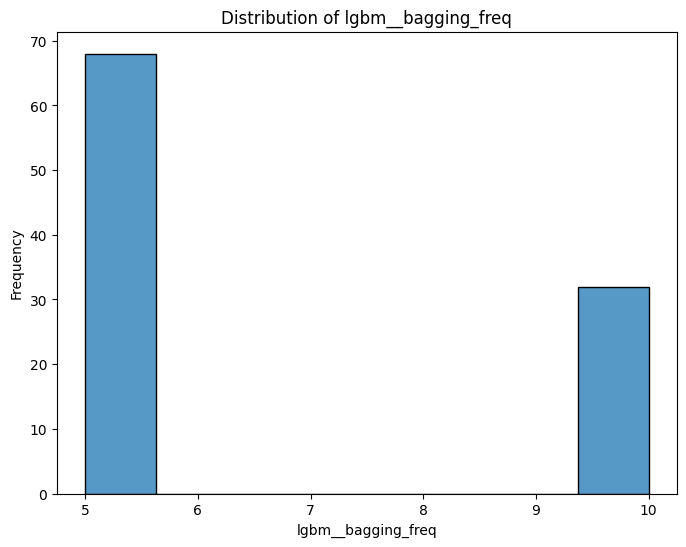

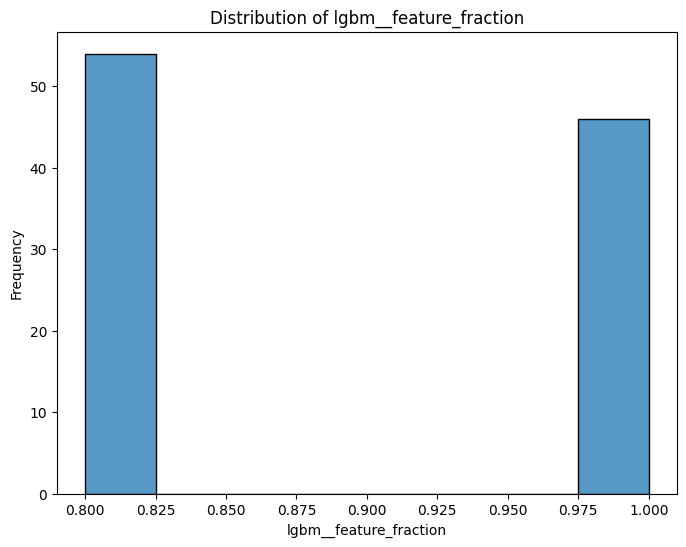

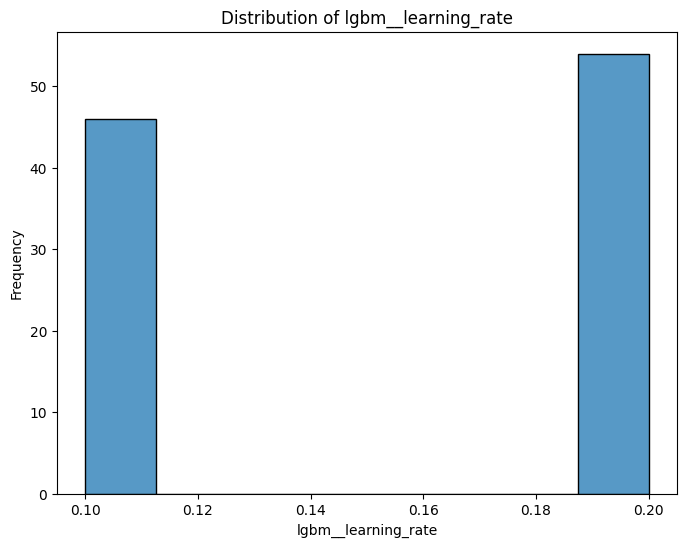

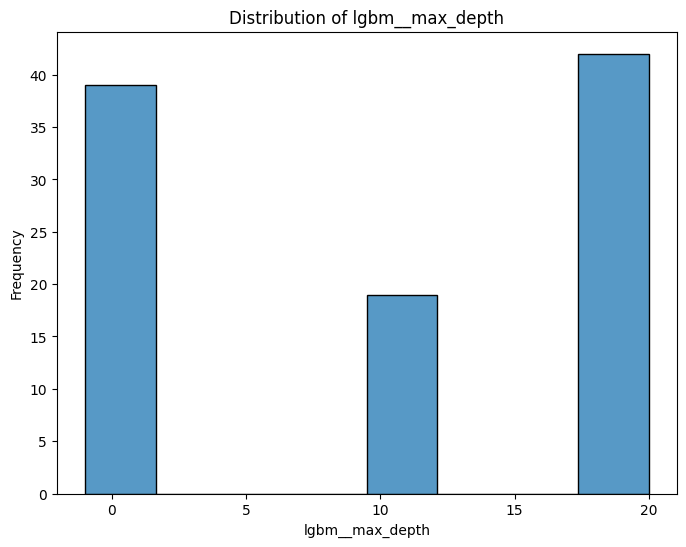

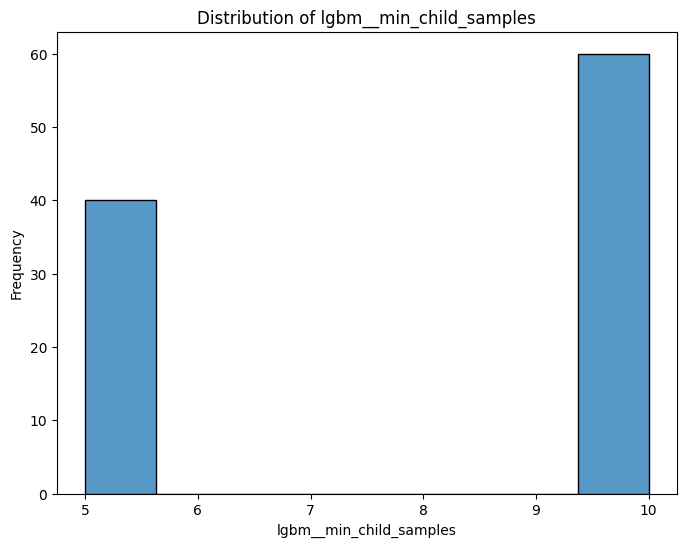

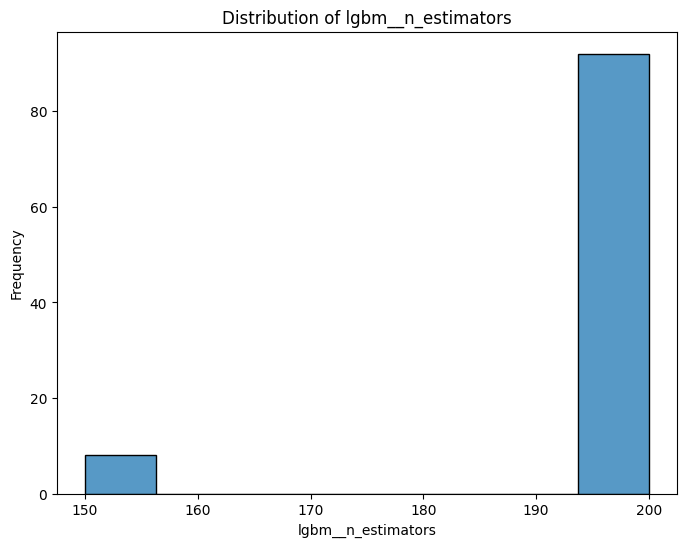

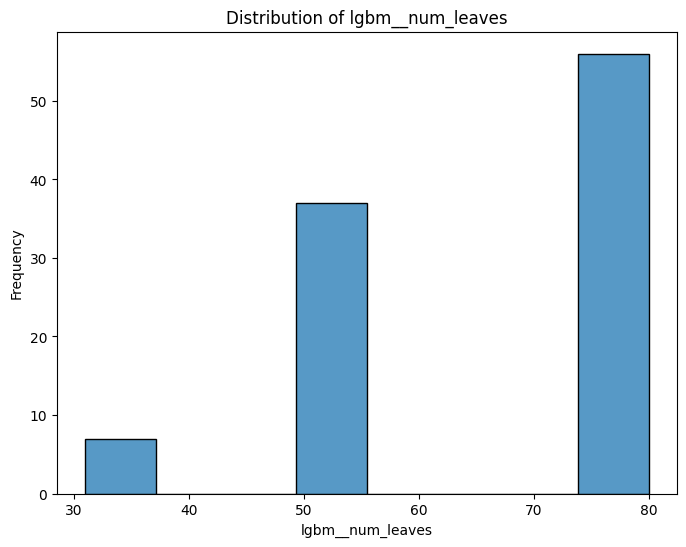

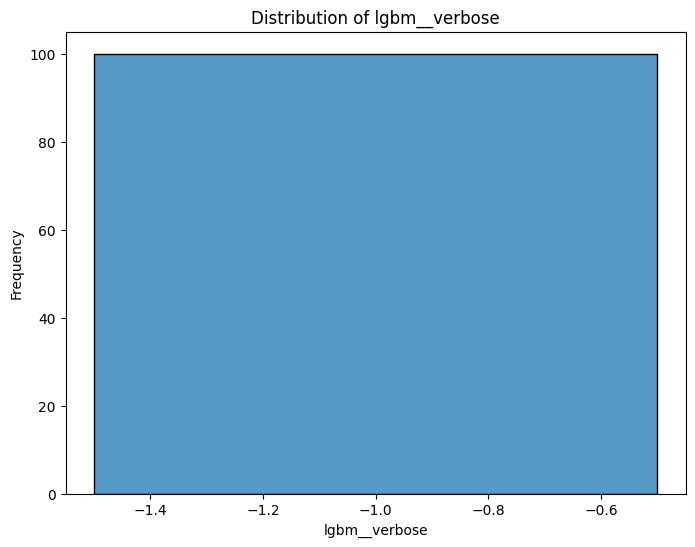

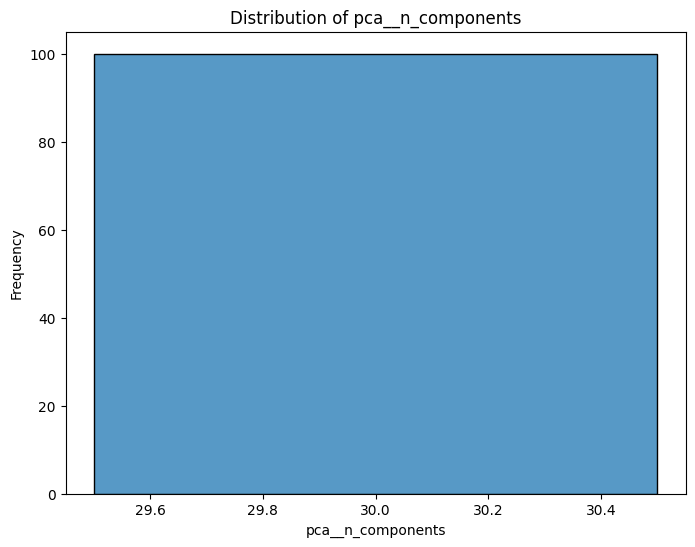

In [149]:
score_df = show_parameter_scores(halving_search)
extract_and_plot_parameter_distributions(score_df)


In [150]:
expanded_params = pd.json_normalize(score_df['params'])
score_df = pd.concat([score_df.drop(columns=['params']), expanded_params], axis=1)
score_df

,mean_test_score,std_test_score,rank_test_score,lgbm__bagging_fraction,lgbm__bagging_freq,lgbm__feature_fraction,lgbm__learning_rate,lgbm__max_depth,lgbm__min_child_samples,lgbm__n_estimators,lgbm__num_leaves,lgbm__verbose,pca__n_components
3454,0.987161,0.000640,1,0.8,10,1.0,0.2,10,5,150,31,-1,10
3455,0.986943,0.000519,2,0.8,10,1.0,0.2,10,5,150,80,-1,10
3452,0.982659,0.000574,3,0.8,10,1.0,0.2,10,5,200,80,-1,10
3453,0.982411,0.000774,4,0.8,10,1.0,0.2,10,5,150,50,-1,10
3450,0.982300,0.000733,5,0.8,10,1.0,0.2,10,5,200,31,-1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,0.795238,0.092746,3451,0.8,10,0.8,0.1,10,10,200,31,-1,10
1455,0.795238,0.092746,3451,0.8,5,0.8,0.1,10,5,150,50,-1,10
1443,0.793137,0.090933,3454,0.8,10,0.8,0.1,10,5,200,31,-1,10
1440,0.793137,0.090933,3454,0.8,10,1.0,0.1,-1,10,150,31,-1,10


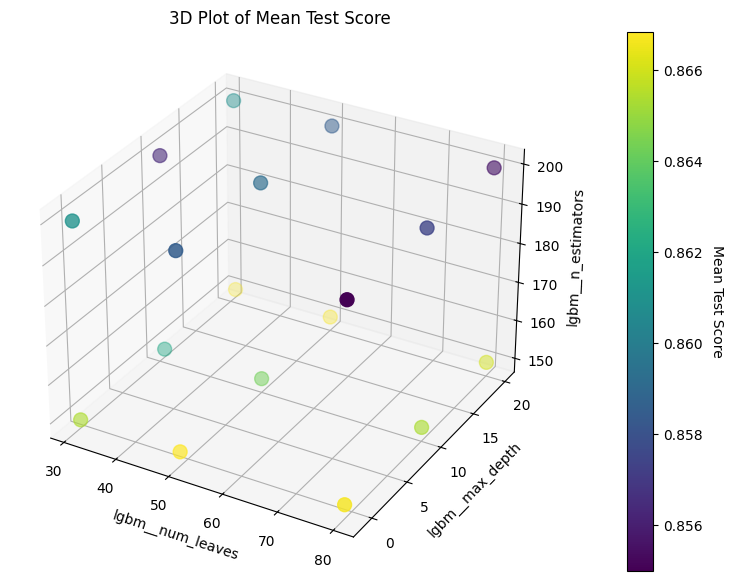

In [153]:
parameter_col = ['lgbm__num_leaves', 'lgbm__max_depth','lgbm__n_estimators']
target_col = 'mean_test_score'
draw_3d_plot(score_df, parameter_col, target_col)

### NN

In [136]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [127]:
def build_model(hyperparams):
    model = keras.Sequential([
        layers.Dense(hyperparams['units_1'], activation='relu', input_shape=(63,)),
        layers.Dropout(hyperparams['dropout_1']),
        layers.Dense(hyperparams['units_2'], activation='relu'),
        layers.Dropout(hyperparams['dropout_2']),
        layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss='binary_crossentropy',
        metrics=[
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(curve='PR', name='pr_auc')]
    )
    return model

In [128]:

def random_search(df, param_space, n_iter=20):
    best_score = -float('inf')
    best_params = {}
    for trial in range(n_iter):
        params = {k: random.choice(v) for k, v in param_space.items()}
        print(f"Trial {trial + 1}: Testing with parameters {params}")
        model = build_model(params)
        X_train, X_test, y_train, y_test = X_y_train_test(df)
        y_test = np.array(y_test)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
        y_train = np.array(y_train)


        batch_size = params["batch_size"]
        num_epochs = params["epochs"]
        early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,  # Stop training if val_loss doesn't improve for 3 consecutive epochs
        restore_best_weights=True
    )
        history = model.fit(X_train, y_train, validation_split=0.2, batch_size=batch_size, epochs=num_epochs, verbose=0,callbacks=[early_stopping])
        loss, precision, recall, PR_AUC = model.evaluate(X_test, y_test, verbose=0)
        print(f"Trial {trial + 1} - Loss: {loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, PR_AUC: {PR_AUC:.4f}")
        if PR_AUC > best_score:
            best_score = PR_AUC
            best_params = params
            best_history = history
    print(f"\nBest Parameters: {best_params}")
    print(f"Best PR_AUC: {best_score:.4f}")
    return best_params, best_score, best_history


In [141]:
def grid_search_nn(df, param_grid):
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

    # print("Devices in use:")
    # tf.debugging.set_log_device_placement(True)
    best_score = -float('inf')
    best_params = {}
    pr_auc_scores = {}
    all_combinations = list(itertools.product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for i, combination in enumerate(all_combinations):
        params = dict(zip(param_names, combination))
        logger.info(f"Trial {i + 1}: Testing with parameters {params}")
        print(f"Trial {i+1}: Testing with parameters {params}")
        model = build_model(params)
        X_train, X_test, y_train, y_test = X_y_train_test(df)
        y_train = np.array(y_train)
        y_test = np.array(y_test)

        batch_size = params["batch_size"]
        num_epochs = params["epochs"]
        early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,  # Stop training if val_loss doesn't improve for 3 consecutive epochs
        restore_best_weights=True
    )
        history=model.fit(X_train, y_train, batch_size=batch_size,validation_split = 0.2, epochs=num_epochs, verbose=0, callbacks=[early_stopping])
        loss, precision, recall, pr_auc = model.evaluate(X_test, y_test, verbose=0)
        # print(f"Trial {i+1}: Loss: {loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, PR_AUC: {pr_auc:.4f}")
        logger.info(
            f"Trial {i + 1}: Loss: {loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, PR_AUC: {pr_auc:.4f}"
        )
        # pr_auc_scores[tuple(params.items())] = pr_auc

        if pr_auc > best_score:
            best_score = pr_auc
            best_params = params
            best_history = history

    print(f"\nBest Parameters: {best_params}")
    print(f"Best Score: {best_score:.4f}")
    logger.info(f"\nBest Parameters: {best_params}")
    logger.info(f"Best Score: {best_score:.4f}")
    return best_params, best_score, best_history



In [131]:
# Hyperparameter space
param_space = {
    'units_1': [64, 128, 256],
    'units_2': [32, 64, 128],
    "dropout_1": [ 0.2, 0.3, 0.4],
    "dropout_2": [0.1, 0.2, 0.3],
    "batch_size": [16, 32, 64],
    "epochs": [25,50,75]
}

#### Random Search

In [143]:
new_df_cat = pd.concat([X_resampled, y_resampled], axis=1)
nn_best_params, nn_best_score,history = random_search(new_df_cat, param_space, n_iter=20)
best_nn_classifier = build_model(nn_best_params)
X_train, X_test, y_train, y_test = X_y_train_test(new_df_cat)
y_train = np.array(y_train)
best_nn_classifier.fit(X_train, y_train, batch_size=nn_best_params["batch_size"], epochs=nn_best_params["epochs"], verbose=0)
joblib.dump(best_nn_classifier, 'nn_rm_model.pkl')

Trial 1: Testing with parameters {'units_1': 64, 'units_2': 32, 'dropout_1': 0.3, 'dropout_2': 0.2, 'batch_size': 16, 'epochs': 25}
Trial 1 - Loss: 0.2435, Precision: 0.9345, Recall: 0.8566, PR_AUC: 0.9670
Trial 2: Testing with parameters {'units_1': 128, 'units_2': 128, 'dropout_1': 0.3, 'dropout_2': 0.3, 'batch_size': 64, 'epochs': 75}
Trial 2 - Loss: 0.1823, Precision: 0.9447, Recall: 0.9058, PR_AUC: 0.9801
Trial 3: Testing with parameters {'units_1': 128, 'units_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.3, 'batch_size': 16, 'epochs': 50}
Trial 3 - Loss: 0.2427, Precision: 0.9390, Recall: 0.8516, PR_AUC: 0.9676
Trial 4: Testing with parameters {'units_1': 64, 'units_2': 64, 'dropout_1': 0.4, 'dropout_2': 0.1, 'batch_size': 32, 'epochs': 25}
Trial 4 - Loss: 0.2480, Precision: 0.9228, Recall: 0.8770, PR_AUC: 0.9665
Trial 5: Testing with parameters {'units_1': 256, 'units_2': 128, 'dropout_1': 0.3, 'dropout_2': 0.3, 'batch_size': 32, 'epochs': 50}
Trial 5 - Loss: 0.2236, Precision: 0.90

['nn_rm_model.pkl']

Loss: 0.1635
Precision: 0.9169
Recall: 0.9526
PR_auc: 0.9862
1632/1632 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Specificity: 0.91
Sensitivity: 0.9526309738243973
Accuracy: 0.9332095053903452
Precision: 0.9169279575048876
F1-score: 0.9344385549415436
MCC: 0.8670792150192956

AUC-ROC: 0.933223255760266
AUC-PR: 0.9466133319687614


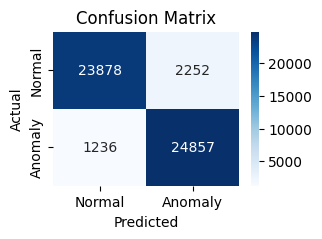

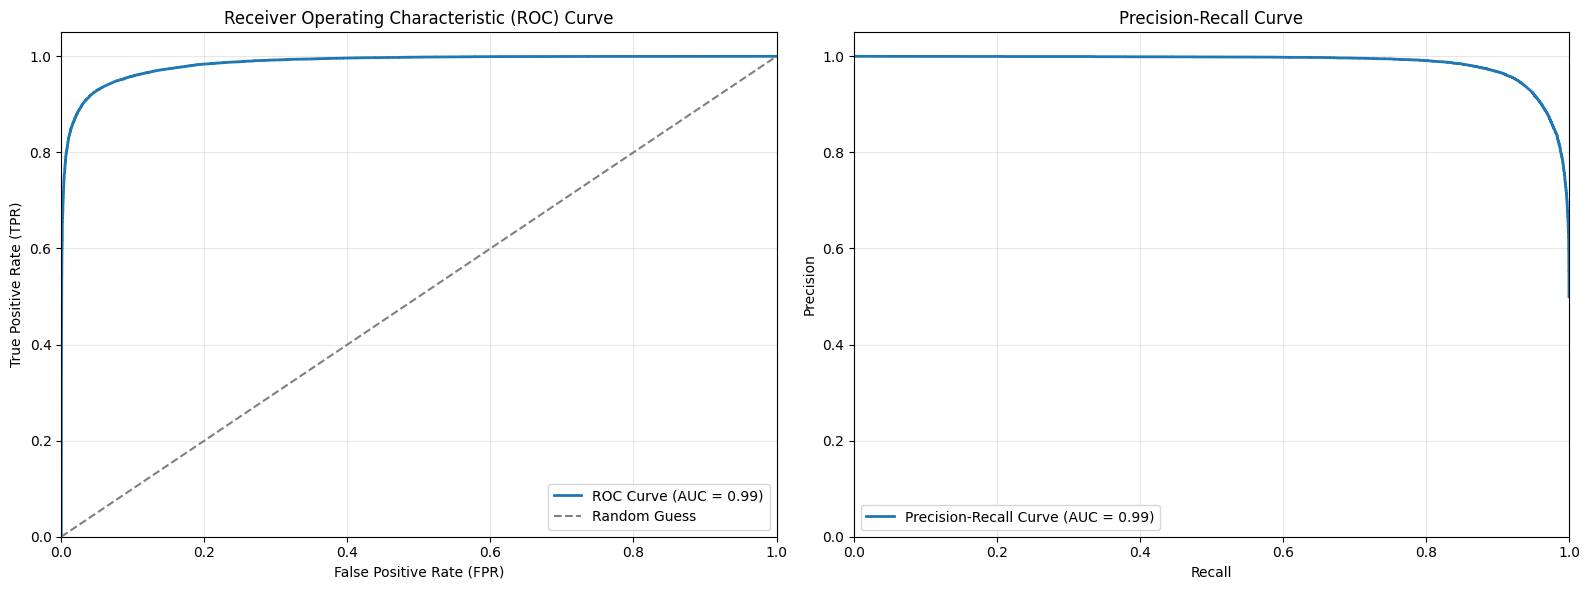

In [144]:
y_test = np.array(y_test)
para_model['nn_rm_classifier'] = best_nn_classifier
loss, precision, recall,pr_auc = best_nn_classifier.evaluate(X_test, y_test, verbose=0)

print(f"Loss: {loss:.4f}")
print(f"Precision: {precision:.4f}")  # Access the precision value directly
print(f"Recall: {recall:.4f}")
print(f"PR_auc: {pr_auc:.4f}")

y_pred_probs = best_nn_classifier.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int) # Convert probabilities to binary predictions
specificity, recall, accuracy, precision, f1, mcc, roc_auc, pr_auc = show_performance(y_test, y_pred)
model_performance['nn_rm_classifier'] = [specificity, recall, accuracy, precision, f1, mcc, roc_auc, pr_auc]
visual_performance(y_test, y_pred, y_pred_probs)

### Isolation Forest

In [157]:
X_train, X_test, y_train, y_test = X_y_train_test(df_onehot)

In [158]:
def random_search_hyperparameter_tuning(pipeline, param_grid, X, y, custom_scorer, n_iter=10):
    best_score = -float('inf')
    best_params = {}
    for _ in range(n_iter):
        params = {}
        for param_name, param_values in param_grid.items():
            params[param_name] = random.choice(param_values)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        pipeline.set_params(**params)
        pipeline.fit(X_train)
        y_pred = pipeline.fit_predict(X_val)
        # y_pred = pipeline.predict(X_val)
        score = custom_scorer(y_pred,y_val)
        if score > best_score:
            best_score = score
            best_params = params

    return best_params, best_score

In [195]:
def custom_scoring(y_pred,y_train):
    y_pred = [1 if p == -1 else 0 for p in y_pred]
    if len(set(y_train)) < 2 or len(set(y_train)) < 2:
        return 0  # Avoid NaN if no anomalies are predicted or present
    return average_precision_score(y_train, y_pred)


In [196]:
def custom_scoring2(y_pred, y_train ):
    y_pred = [1 if p == -1 else 0 for p in y_pred]
    if len(set(y_train)) < 2 or len(set(y_train)) < 2:
        return 0  # Avoid NaN if no anomalies are predicted or present
    return accuracy_score(y_true=y_train, y_pred = y_pred)

In [202]:
param_if = {
    'pca__n_components': [5, 10, 15, 20, 25],
    'if__n_estimators': [100, 200, 300],
    'if__max_samples': [0.5, 0.75, 1.0],
    'if__max_features': [0.5, 0.75, 1.0],
    'if__bootstrap': [True, False],
    'if__contamination': [ 0.08, 0.1, 0.15, 0.2],
    'if__n_jobs' : [-1],
    'if__random_state': [42]
}
pipeline = Pipeline([
    ('pca', PCA()),
    ('if', IsolationForest())
])

Best Hyperparameters: {'pca__n_components': 5, 'if__n_estimators': 200, 'if__max_samples': 0.75, 'if__max_features': 0.75, 'if__bootstrap': False, 'if__contamination': 0.08, 'if__n_jobs': -1, 'if__random_state': 42}
Best Recall/TPR Score: 0.15800400971963902
Specificity: 0.93
Sensitivity: 0.3231173380035026
Accuracy: 0.884511013215859
Precision: 0.29890643985419196
F1-score: 0.31054071112981274
MCC: 0.24784570742719053

AUC-ROC: 0.6283863107172853
AUC-PR: 0.33825417967774596


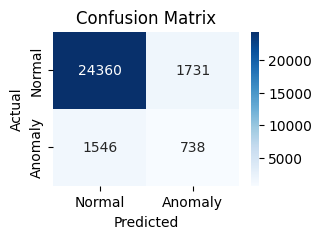

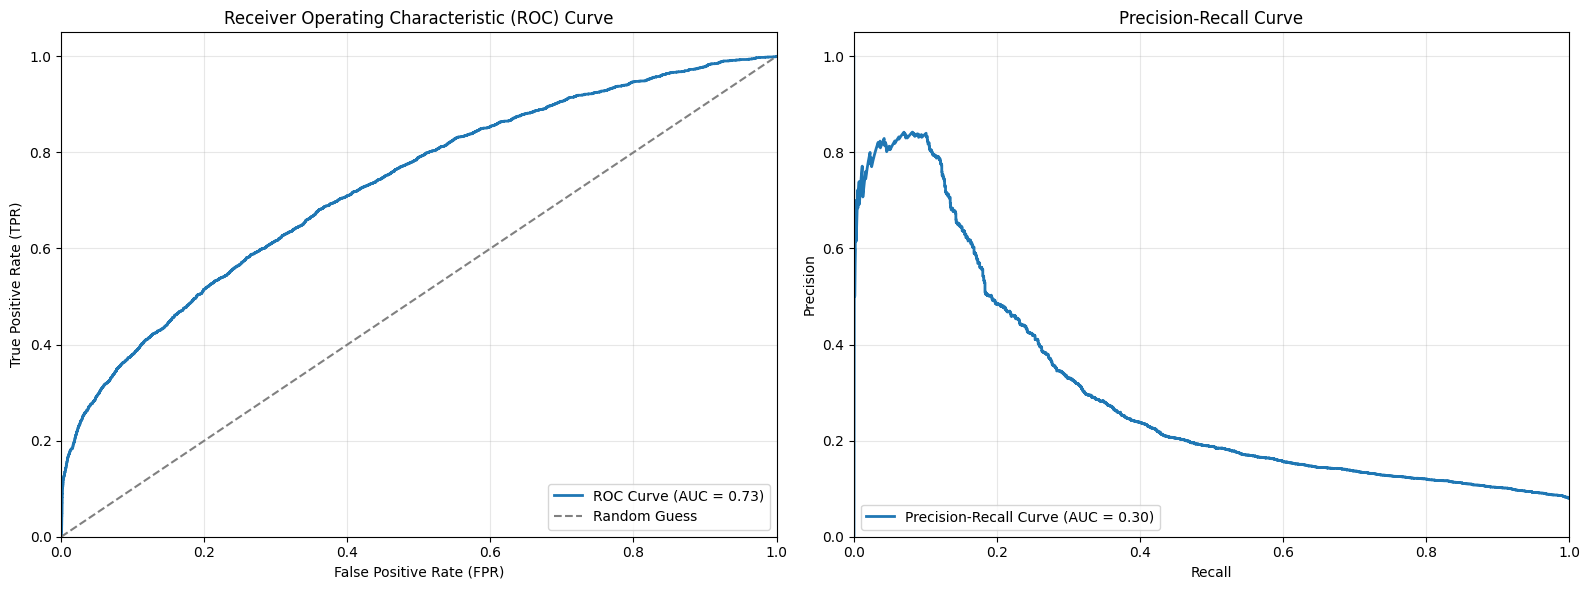

In [203]:
para,score = random_search_hyperparameter_tuning(pipeline, param_if, X_train, y_train, custom_scoring, n_iter=20)
print("Best Hyperparameters:", para)
print("Best Recall/TPR Score:", score)
pipeline.set_params(**para)
pipeline.fit(X_train)
joblib.dump(pipeline, 'IF.pkl')
y_pred = pipeline.predict(X_test)
y_pred_probs = pipeline.decision_function(X_test)
y_pred_proba = (y_pred_probs- np.min(y_pred_probs))/(np.max(y_pred_probs)-np.min(y_pred_probs))
y_pred_proba = 1 - y_pred_proba
new_y_pred = [0 if x == 1 else 1 for x in y_pred]

specificity, recall, accuracy, precision, f1, mcc, roc_auc, pr_auc = show_performance(y_test, new_y_pred)
model_performance['IF_cluster'] = [specificity, recall, accuracy, precision, f1, mcc, roc_auc, pr_auc]
visual_performance(y_test, new_y_pred, y_pred_proba)

### DBSCAN

In [198]:
param_dbscan = {
    'dbscan__eps': [0.1, 0.5, 1.0, 1.5, 2.0],
    'dbscan__min_samples': [5, 10, 15, 20, 25],
    'pca__n_components': [5,10,15,20,25] # Added n_components for PCA
}

pipeline = Pipeline([
    ('pca', PCA()),
    ('dbscan', DBSCAN())
])
para,score = random_search_hyperparameter_tuning(pipeline, param_dbscan, X_train, y_train, custom_scoring2, n_iter=20)

In [199]:
print("Best Hyperparameters:", para)
print("Best Score:", score)
pipeline.set_params(**para)
pipeline.fit(X_train)
joblib.dump(pipeline, 'DBSCAN.pkl')

Best Hyperparameters: {'dbscan__eps': 1.5, 'dbscan__min_samples': 5, 'pca__n_components': 10}
Best Score: 0.8049339207048458


['DBSCAN.pkl']

In [200]:
y_pred = pipeline.fit_predict(X_test)
"""y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred_proba = (y_pred_proba- np.min(y_pred_proba))/(np.max(y_pred_proba)-np.min(y_pred_proba))
y_pred_proba = 1 - y_pred_proba"""
new_y_pred = [1 if x == -1 else 0 for x in y_pred]
specificity, recall, accuracy, precision, f1, mcc, roc_auc, pr_auc = show_performance(y_test, new_y_pred)
model_performance['DBSCAN_cluster'] = [specificity, recall, accuracy, precision, f1, mcc, roc_auc, pr_auc]
para_model['DBSCAN_cluster'] = pipeline
# visual_performance(y_test, new_y_pred, None)

Specificity: 0.85
Sensitivity: 0.478984238178634
Accuracy: 0.8186431718061674
Precision: 0.21663366336633663
F1-score: 0.29833651486228524
MCC: 0.2328434001708357

AUC-ROC: 0.663680536551277
AUC-PR: 0.36877811376808006


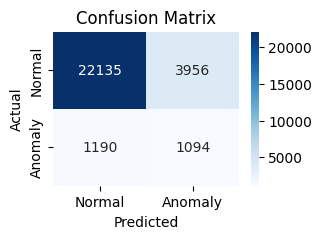

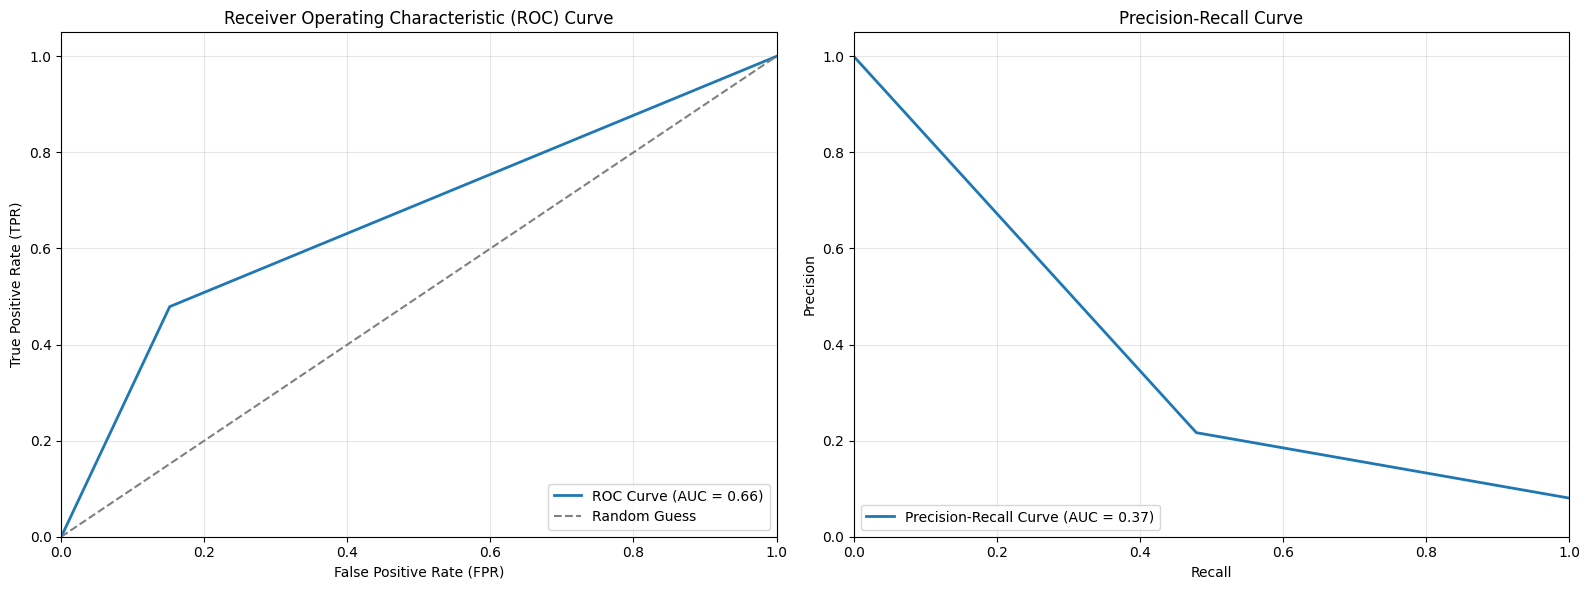

In [201]:
visual_performance(y_test, new_y_pred, None)

Best Hyperparameters: {'dbscan__eps': 1.5, 'dbscan__min_samples': 15, 'pca__n_components': 5}
Best Score: 0.19255948154437386
Specificity: 0.98
Sensitivity: 0.24737302977232925
Accuracy: 0.9218325991189428
Precision: 0.5310150375939849
F1-score: 0.3375149342891278
MCC: 0.32685876284151877

AUC-ROC: 0.6141238304355878
AUC-PR: 0.41948478258183547


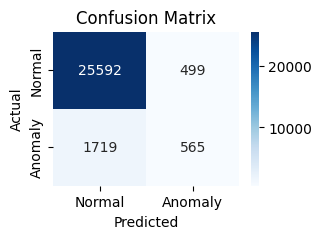

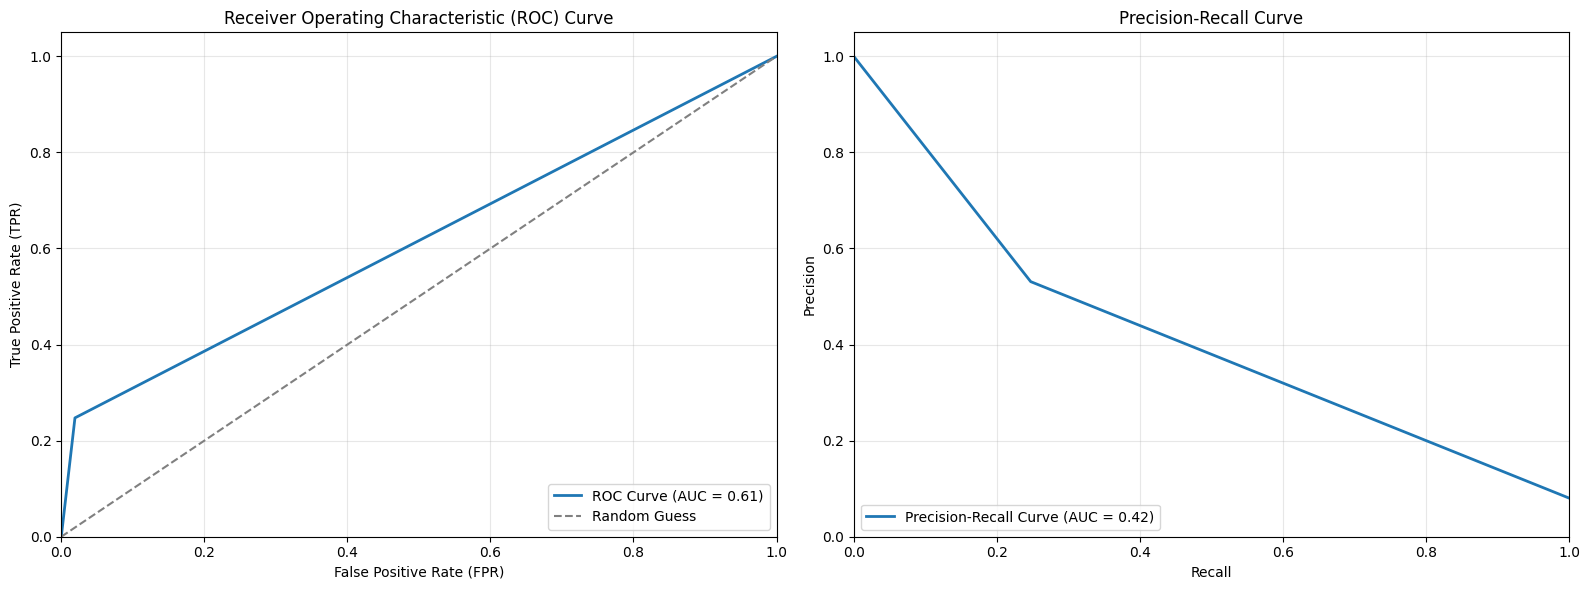

In [197]:
param_dbscan = {
    'dbscan__eps': [0.1, 0.5, 1.0, 1.5, 2.0],
    'dbscan__min_samples': [5, 10, 15, 20, 25],
    'pca__n_components': [5,10,15,20,25] # Added n_components for PCA
}

pipeline = Pipeline([
    ('pca', PCA()),
    ('dbscan', DBSCAN())
])
para,score = random_search_hyperparameter_tuning(pipeline, param_dbscan, X_train, y_train, custom_scoring, n_iter=20)
print("Best Hyperparameters:", para)
print("Best Score:", score)
pipeline.set_params(**para)
pipeline.fit(X_train)
y_pred = pipeline.fit_predict(X_test)
new_y_pred = [1 if x == -1 else 0 for x in y_pred]
specificity, recall, accuracy, precision, f1, mcc, roc_auc, pr_auc = show_performance(y_test, new_y_pred)
visual_performance(y_test, new_y_pred, None)

In [206]:
model_performance_df.to_csv('model_performance.csv')

## Result Visualization

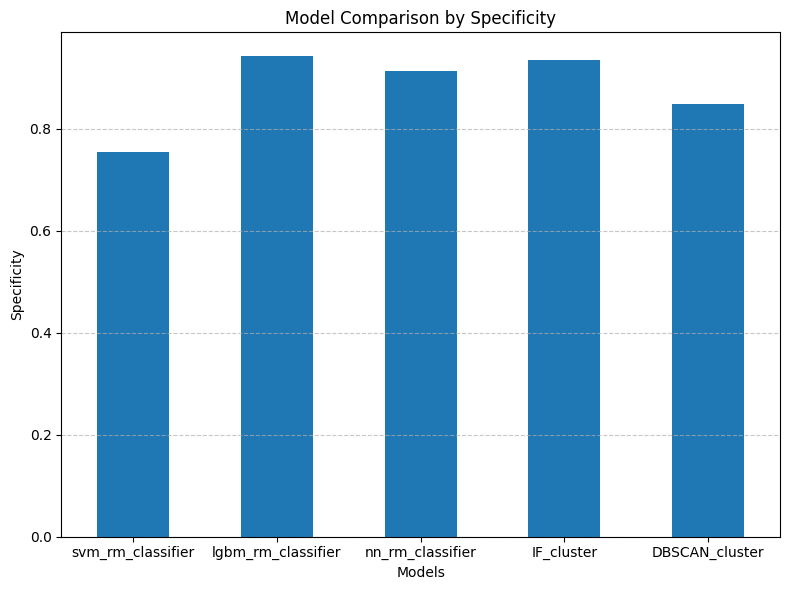

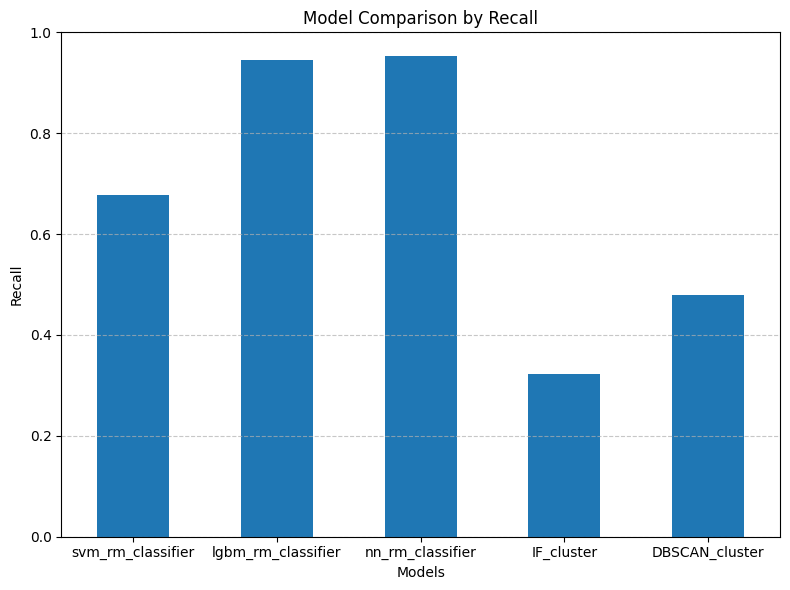

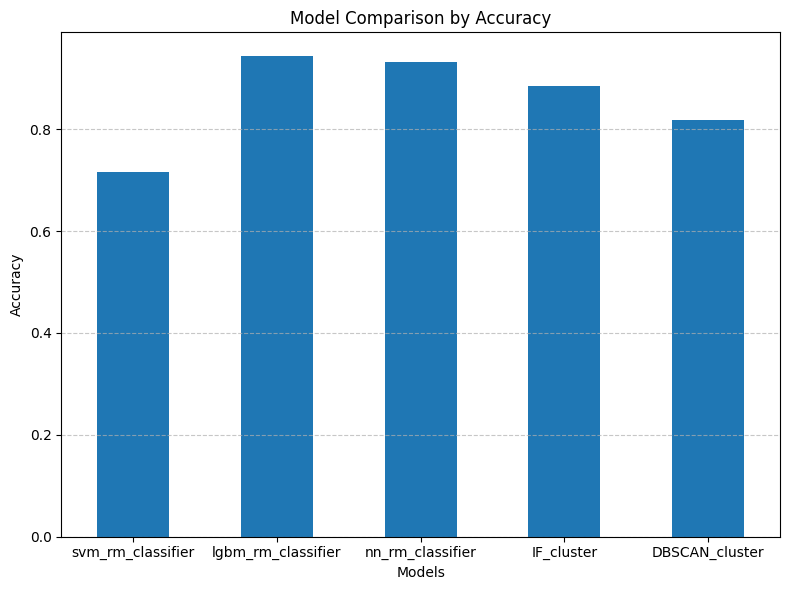

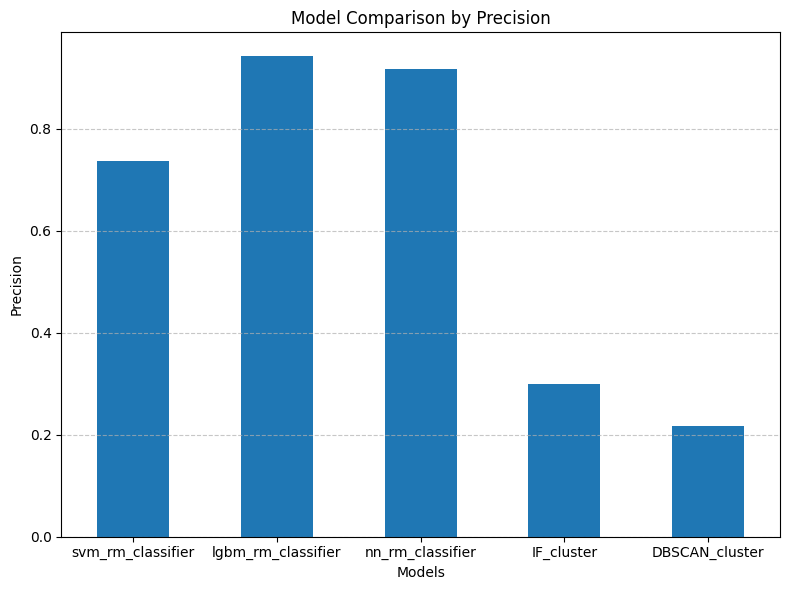

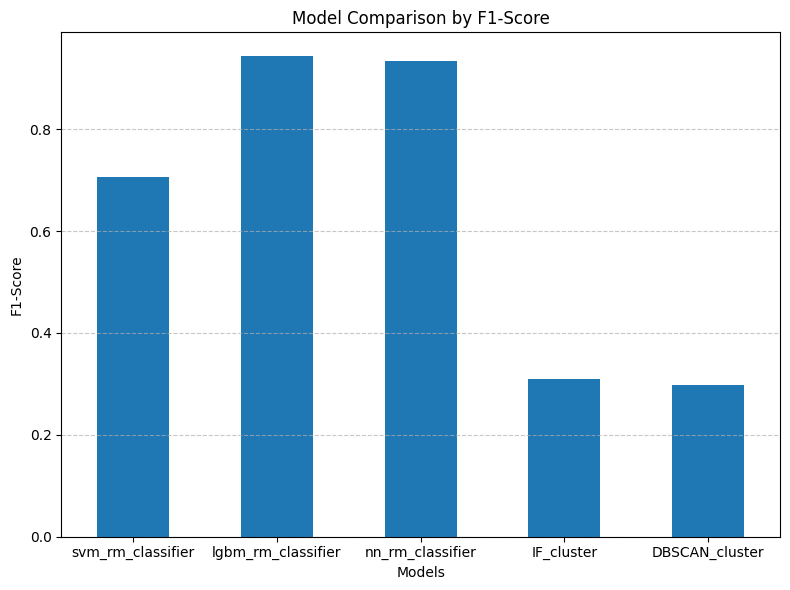

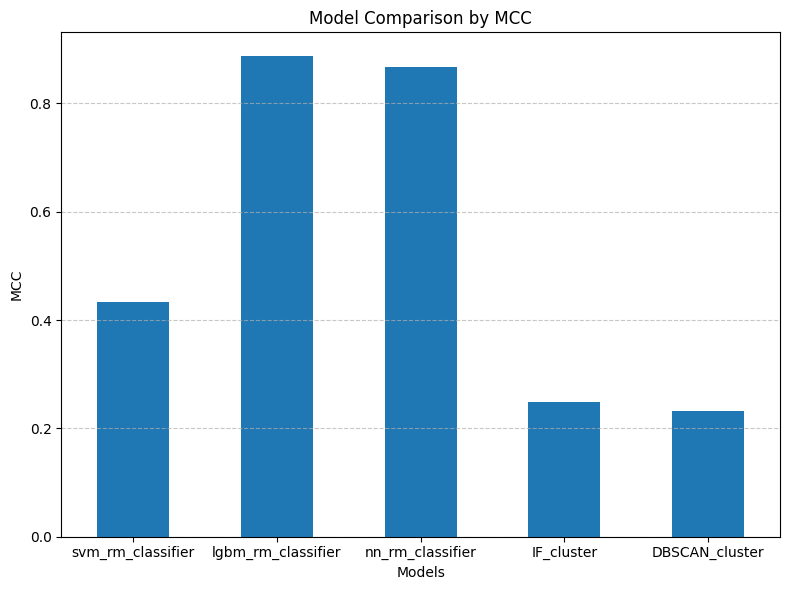

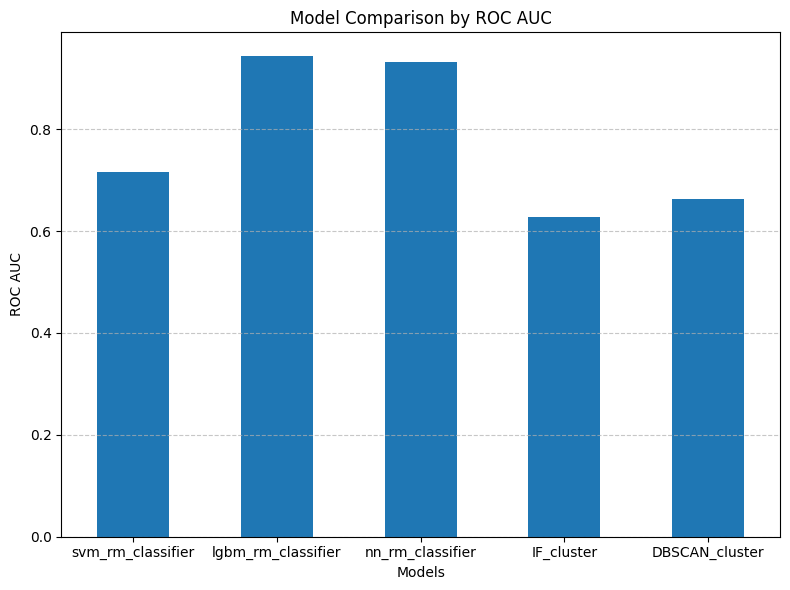

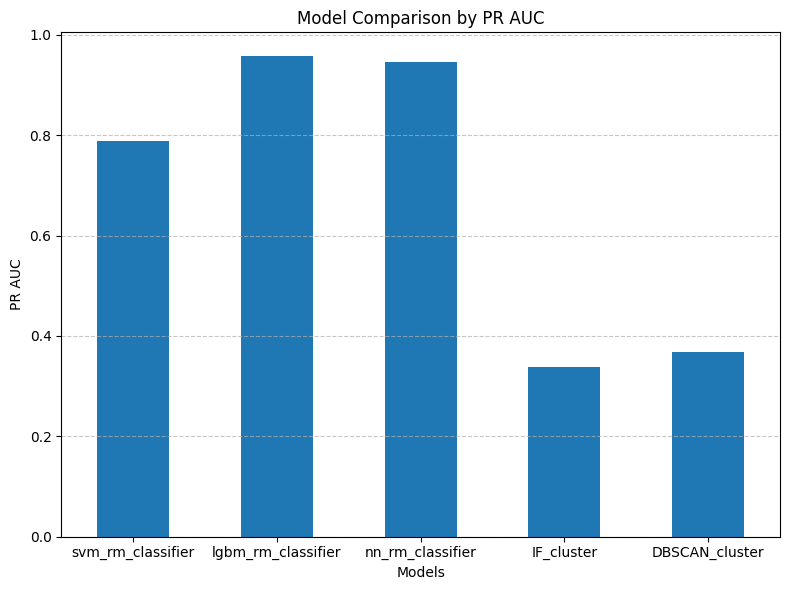

In [205]:

model_performance_df = pd.DataFrame.from_dict(model_performance, orient='index', columns=['Specificity', 'Recall', 'Accuracy', 'Precision', 'F1-Score', 'MCC', 'ROC AUC', 'PR AUC'])

metrics = model_performance_df.columns
for metric in metrics:
    plt.figure(figsize=(8, 6))
    model_performance_df[metric].plot(kind='bar', rot=0)
    plt.title(f'Model Comparison by {metric}')
    plt.ylabel(metric)
    plt.xlabel('Models')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

<Figure size 1200x800 with 0 Axes>

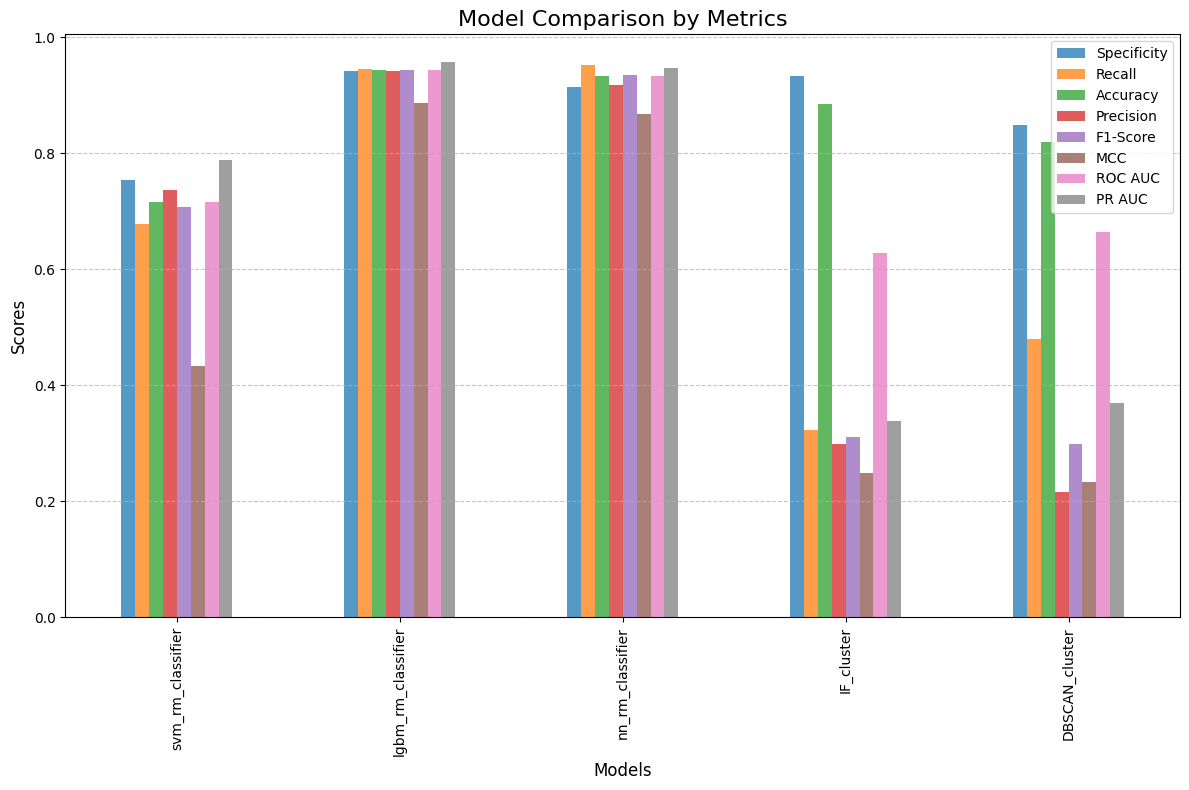

In [210]:
plt.figure(figsize=(12, 8))
model_performance_df.plot(kind='bar', figsize=(12, 8), alpha=0.75)
plt.title('Model Comparison by Metrics', fontsize=16)
plt.ylabel('Scores', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()